In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier
import optuna
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from library.Data_Preprocessing import Balance_Ratio
from library.Imbalance_Sampling import label_divide, under_over, over_under
from library.Aging_Score_Contour import score1
from library.AdaBoost import train_set, multiple_set, multiple_month, line_chart, cf_matrix, all_optuna

os.chdir('C:/Users/user/Desktop/Darui_R08621110') 
os.getcwd()

'C:\\Users\\user\\Desktop\\Darui_R08621110'

## 

### balance cascade

In [2]:
class BalanceCascade:
    
    def __init__(self, base_clf = 'LightGBM', num_iter = 10, over_method = None, over_num = 10, verbose = False):
        self.classifier = base_clf
        self.num_iter = num_iter
        self.over_method = over_method if over_method else None
        self.over_num = over_num if over_method else 1
        self.verbose = verbose

    
    def training(self, train_data, clf_config):
        origin_good = train_data[train_data.GB == 0]
        origin_bad = train_data[train_data.GB == 1] 
        br_0 = (len(origin_bad)*self.over_num) / len(origin_good)
        false_rate = br_0**(1/(self.num_iter - 1))
        
        keep_bad = origin_bad.copy()
        keep_good = {0: origin_good.copy()}
        br_list = np.array([br_0])
        clf_threshold = []
        clf_cascade = {}
        for j in range(self.num_iter):
            if self.over_method:
                if self.verbose:
                    print(f'\nIteration {j+1}:')
                temp_combine = pd.concat([keep_good[j], keep_bad], axis = 0)
                over_ratio = np.min([br_list[j]*self.over_num, 1])
                X, Y = under_over(temp_combine, self.over_method, None, over_ratio, 0)
                resample = pd.concat([X, Y], axis = 1)
                resample = resample.rename({0: 'GB'}, axis = 'columns')
                over_bad = resample[resample.GB == 1]
            else:
                over_bad = keep_bad.copy()

            if all([j != (self.num_iter - 1), len(keep_good[j]) > len(over_bad)]):
                draw = random.sample(keep_good[j].index.to_list(), len(over_bad))
                draw_good = keep_good[j].loc[draw]
                train_combine = pd.concat([draw_good, over_bad], axis = 0)
            else:
                train_combine = pd.concat([keep_good[j], keep_bad], axis = 0)
                if all([self.over_method, j != (self.num_iter - 1)]):
                    print('Stop oversampling !')

            valid_good = keep_good[j].copy()
            train_x, train_y, valid_x, valid_y = label_divide(train_combine, valid_good, 'GB', train_only = False)
            if self.classifier == 'LightGBM':
                clf = LGBMClassifier(**clf_config)
            elif self.classifier == 'RandomForest':
                clf = RandomForestClassifier(**clf_config)
            clf.fit(train_x, train_y)
            predict = clf.predict_proba(valid_x)[:, 1]
            predict_df = pd.DataFrame(dict(predict = predict), index = valid_x.index)
            predict_df = predict_df.sort_values(by = 'predict', ascending = False)
            keep_num = int(len(predict_df)*false_rate)
            keep_index = predict_df.index[:keep_num]
            threshold = predict_df.loc[keep_index[-1]].values[0]
            clf_threshold.append(threshold)
            clf_cascade[j] = clf
            
            if j != (self.num_iter - 1):
                temp_good = keep_good[j].loc[keep_index]
                br_temp = len(keep_bad) / len(temp_good)
                br_list = np.append(br_list, br_temp)
                keep_good[j+1] = temp_good.copy()        
        self.good_data = keep_good
        self.bad_data = keep_bad
        self.threshold = clf_threshold
        self.cascade = clf_cascade
        self.balance_ratio = br_list

        return clf_cascade, clf_threshold
    
    
    def testing(self, test_data, clf_cascade, clf_threshold):
        if isinstance(clf_threshold, int):
            clf_threshold = [clf_threshold]*len(clf_cascade)

        test_x, test_y = label_divide(test_data, 'GB', train_only = True)
        predict_df = pd.DataFrame()
        for i in range(len(clf_cascade)):
            clf = clf_cascade[i]
            predict = clf.predict_proba(test_x)[:, 1]
            answer = (predict > clf_threshold[i]).astype(int)
            predict = pd.DataFrame({str(i): answer})
            predict_df = pd.concat([predict_df, predict], axis = 1)
        predict_y = (predict_df.apply(sum, axis = 1) == len(clf_cascade)).astype(int)
        result = pd.DataFrame(dict(predict = predict_y, truth = test_y))

        return result


def runall_cascade(train_set, test_data, base_config, base_clf = 'LightGBM', num_iter = 10, meta_config = None):
    
    num_set = len(train_set)
    table_set = pd.DataFrame()
    for i in range(num_set):
        print('\n', f'Dataset {i}:')
        if isinstance(meta_config, dict):
            BC = BalanceCascade(base_clf = base_clf, **meta_config[f'set{i}'])
        else:
            BC = BalanceCascade(base_clf = base_clf, num_iter = num_iter)
        clf_cascade, clf_threshold = BC.training(train_set[f'set{i}'], base_config[f'set{i}'])
        result = BC.testing(test_data, clf_cascade, clf_threshold)
        table = cf_matrix(result, train_set[f'set{i}'].GB)
        table_set = pd.concat([table_set, table]).rename(index = {0: f'dataset {i}'})
    
    return table_set

### optuna

In [51]:
def BalanceCascade_creator(train_data, mode, num_valid = 3, label = 'GB') :

    def objective(trial) :

        base_param = {
            'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'goss']),
            'n_estimators': trial.suggest_int('n_estimators', 100, 300, step = 50),
            'subsample': trial.suggest_float('subsample', 0.5, 0.9, step = 0.2),
            'num_leaves': trial.suggest_int('num_leaves', 5, 40, step = 5),
            'min_child_samples': trial.suggest_int('min_child_samples', 3, 24, step = 3),
            'max_depth': trial.suggest_int('max_depth', 3, 15, step = 2),
            'learning_rate': trial.suggest_float('learning_rate', 0.025, 0.425, step = 0.05),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 5), # alpha
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 5) # lambda
        }
    
        meta_param = {
            'num_iter': trial.suggest_int('num_iter', 5, 5, step = 5),
            'over_num': trial.suggest_int('over_num', 10, 10, step = 5),
            'over_method': trial.suggest_categorical('over_method', ['ADASYN'])
        }
        

        result_list = []
        for i in range(num_valid):

            train_good = train_data[train_data.GB == 0]
            train_bad = train_data[train_data.GB == 1]
            train_good_x, train_good_y = label_divide(train_good, None, label, train_only = True)
            train_bad_x, train_bad_y = label_divide(train_bad, None, label, train_only = True)
            train_g_x, valid_g_x, train_g_y, valid_g_y = train_test_split(train_good_x, train_good_y, test_size = 0.25)
            train_b_x, valid_b_x, train_b_y, valid_b_y = train_test_split(train_bad_x, train_bad_y, test_size = 0.25)
            train_x = pd.concat([train_g_x, train_b_x], axis = 0)
            train_y = pd.concat([train_g_y, train_b_y], axis = 0)
            valid_x = pd.concat([valid_g_x, valid_b_x], axis = 0)
            valid_y = pd.concat([valid_g_y, valid_b_y], axis = 0)
            all_train = pd.concat([train_x, train_y], axis = 1)
            all_valid = pd.concat([valid_x, valid_y], axis = 1)

            if mode == 1:
                BC = BalanceCascade(base_clf = 'LightGBM', num_iter = meta_param['num_iter'])
            elif mode == 2:
                BC = BalanceCascade(base_clf = 'LightGBM', num_iter = meta_param['num_iter'], 
                                    over_method = meta_param['over_method'], over_num = meta_param['over_num'])
            clf_cascade, clf_threshold = BC.training(all_train, base_param)
            result = BC.testing(all_valid, clf_cascade, clf_threshold)
            table = cf_matrix(result, valid_y)
            recall = table['Recall'].values
            precision = table['Precision'].values
            beta = 1
            if (recall + precision) > 0:
                fscore = ((1+beta**2)*recall*precision) / (recall+(beta**2)*precision)
            else:
                fscore = 0
            result_list.append(fscore)

        return np.mean(result_list)
    return objective

## 

### loading hyperparameters & datasets

In [31]:
### training data ###
training_month = range(2, 5)

data_dict, trainset_x, trainset_y = multiple_month(training_month, num_set = 10, filename = 'dataset')

print('\nCombined training data:\n')
run_train = multiple_set(num_set = 10)
run_train_x, run_train_y = train_set(run_train, num_set = 10)

### testing data ###
run_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
run_test_x, run_test_y = label_divide(run_test, None, 'GB', train_only = True)
print('\n', 'Dimension of testing data:', run_test.shape)


Month 2:

Dimension of dataset 0 : (39009, 88)  balance ratio: 564.35
Dimension of dataset 1 : (3484, 88)  balance ratio: 25.0
Dimension of dataset 2 : (6786, 88)  balance ratio: 25.0
Dimension of dataset 3 : (5356, 88)  balance ratio: 25.0
Dimension of dataset 4 : (3562, 88)  balance ratio: 25.0
Dimension of dataset 5 : (3580, 88)  balance ratio: 26.54
Dimension of dataset 6 : (3712, 88)  balance ratio: 13.17
Dimension of dataset 7 : (3654, 88)  balance ratio: 16.91
Dimension of dataset 8 : (3588, 88)  balance ratio: 25.0
Dimension of dataset 9 : (1794, 88)  balance ratio: 25.0

 10 datasets are loaded.

Labels of  10 datasets are divided.

Month 3:

Dimension of dataset 0 : (60396, 97)  balance ratio: 533.48
Dimension of dataset 1 : (5512, 97)  balance ratio: 25.0
Dimension of dataset 2 : (7956, 97)  balance ratio: 25.0
Dimension of dataset 3 : (8788, 97)  balance ratio: 25.0
Dimension of dataset 4 : (5850, 97)  balance ratio: 25.0
Dimension of dataset 5 : (5887, 97)  balance ratio:

### search for the best hyperparameters

In [ ]:
best_paramC, all_scoreC = all_optuna(num_set = len(run_train), 
                                     all_data = run_train, 
                                     mode = 2, 
                                     TPE_multi = False, 
                                     n_iter = 200,
                                     filename = 'runhist_array_m2m4_m5_3criteria_br25_over2_iter5_over10_BalanceCascade',
                                     creator = BalanceCascade_creator
                                    )

meta_item = ['num_iter', 'over_num', 'over_method']
base_paramC = {}
meta_paramC = {}
for i in range(len(run_train)):
    base_paramC.update({f'set{i}': {}})
    meta_paramC.update({f'set{i}': {}})
    [base_paramC[f'set{i}'].update({a: b}) for (a, b) in best_paramC[f'set{i}'].items() if a not in meta_item]
    [meta_paramC[f'set{i}'].update({a: b}) for (a, b) in best_paramC[f'set{i}'].items() if a in meta_item]

  0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-02-21 22:01:19,525] A new study created in memory with name: no-name-914feb9d-da47-4105-9afa-b13e21170ba1


Dataset0 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Size before Oversampling: 117861
Size after Oversampling: 140438
Size before Oversampling: 44119
Size after Oversampling: 46175
Size before Oversampling: 16604
Size after Oversampling: 18660
Size before Oversampling: 6338
Size after Oversampling: 8388
Size before Oversampling: 2507
Size after Oversampling: 4524
Precision: 0.03260869565217391 
Recall: 0.07894736842105263 
Aging Rate: 0.009424298299528785
Size before Oversampling: 117861
Size after Oversampling: 140481
Size before Oversampling: 44119
Size after Oversampling: 46120
Size before Oversampling: 16604
Size after Oversampling: 18693
Size before Oversampling: 6338
Size after Oversampling: 8427
Size before Oversampling: 2507
Size after Oversampling: 4559
Precision: 0.013513513513513514 
Recall: 0.022727272727272728 
Aging Rate: 0.00753257328990228
Size before Oversampling: 117861
Size after Oversampling: 140423
Size before Oversampling: 44119
Size after Oversampling: 46156
Size before Oversampling: 16604
Size after Oversampling: 

Size before Oversampling: 2507
Size after Oversampling: 4583
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.010851760851760851
Size before Oversampling: 117861
Size after Oversampling: 140400
Size before Oversampling: 44119
Size after Oversampling: 46125
Size before Oversampling: 16604
Size after Oversampling: 18610
Size before Oversampling: 6338
Size after Oversampling: 8344
Size before Oversampling: 2507
Size after Oversampling: 4589
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.010664806139738862
Size before Oversampling: 117861
Size after Oversampling: 140444
Size before Oversampling: 44119
Size after Oversampling: 46155
Size before Oversampling: 16604
Size after Oversampling: 18640
Size before Oversampling: 6338
Size after Oversampling: 8376
Size before Oversampling: 2507
Size after Oversampling: 4543
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.010364289379168804
[I 2022-02-21 22:02:33,889] Trial 5 finished with value: 0.0 and parameters: {'boosting_type': 'goss', 'n_estimators': 100, 'su

Size before Oversampling: 6338
Size after Oversampling: 8421
Size before Oversampling: 2507
Size after Oversampling: 4577
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.008290364978263067
Size before Oversampling: 117861
Size after Oversampling: 140414
Size before Oversampling: 44119
Size after Oversampling: 46201
Size before Oversampling: 16604
Size after Oversampling: 18639
Size before Oversampling: 6338
Size after Oversampling: 8414
Size before Oversampling: 2507
Size after Oversampling: 4571
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.009268690160928907
[I 2022-02-21 22:03:38,382] Trial 10 finished with value: 0.0 and parameters: {'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 5, 'min_child_samples': 18, 'max_depth': 15, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.00015531902168694286, 'reg_lambda': 0.17372457242413222, 'num_iter': 5, 'over_num': 10, 'over_method': 'ADASYN'}. Best is trial 0 with value: 0.02103433289873968.
Size before Oversamplin

Size before Oversampling: 117861
Size after Oversampling: 140411
Size before Oversampling: 44119
Size after Oversampling: 46181
Size before Oversampling: 16604
Size after Oversampling: 18666
Size before Oversampling: 6338
Size after Oversampling: 8400
Size before Oversampling: 2507
Size after Oversampling: 4569
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.009006242963872684
[I 2022-02-21 22:04:39,348] Trial 15 finished with value: 0.0 and parameters: {'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.125, 'reg_alpha': 1.876475839962038, 'reg_lambda': 0.5753468173980442, 'num_iter': 5, 'over_num': 10, 'over_method': 'ADASYN'}. Best is trial 0 with value: 0.02103433289873968.
Size before Oversampling: 117861
Size after Oversampling: 140365
Size before Oversampling: 44119
Size after Oversampling: 46189
Size before Oversampling: 16604
Size after Oversampling: 18678
Size before Oversampling: 6338
Size 

Size before Oversampling: 117861
Size after Oversampling: 140487
Size before Oversampling: 44119
Size after Oversampling: 46172
Size before Oversampling: 16604
Size after Oversampling: 18657
Size before Oversampling: 6338
Size after Oversampling: 8391
Size before Oversampling: 2507
Size after Oversampling: 4552
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.007575757575757576
Size before Oversampling: 117861
Size after Oversampling: 140457
Size before Oversampling: 44119
Size after Oversampling: 46187
Size before Oversampling: 16604
Size after Oversampling: 18669
Size before Oversampling: 6338
Size after Oversampling: 8395
Size before Oversampling: 2507
Size after Oversampling: 4550
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.010357912009024715
Size before Oversampling: 117861
Size after Oversampling: 140416
Size before Oversampling: 44119
Size after Oversampling: 46168
Size before Oversampling: 16604
Size after Oversampling: 18646
Size before Oversampling: 6338
Size after Oversampling: 838

Size before Oversampling: 2507
Size after Oversampling: 4555
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.009769003765136867
Size before Oversampling: 117861
Size after Oversampling: 140365
Size before Oversampling: 44119
Size after Oversampling: 46194
Size before Oversampling: 16604
Size after Oversampling: 18679
Size before Oversampling: 6338
Size after Oversampling: 8413
Size before Oversampling: 2507
Size after Oversampling: 4572
Precision: 0.011494252873563218 
Recall: 0.022222222222222223 
Aging Rate: 0.008887526815813668
Size before Oversampling: 117861
Size after Oversampling: 140453
Size before Oversampling: 44119
Size after Oversampling: 46122
Size before Oversampling: 16604
Size after Oversampling: 18607
Size before Oversampling: 6338
Size after Oversampling: 8338
Size before Oversampling: 2507
Size after Oversampling: 4587
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.009662327095199348
[I 2022-02-21 22:06:58,205] Trial 26 finished with value: 0.005050505050505051 and parameters

Size before Oversampling: 6338
Size after Oversampling: 8433
Size before Oversampling: 2507
Size after Oversampling: 4580
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.008616268335213869
Size before Oversampling: 117861
Size after Oversampling: 140436
Size before Oversampling: 44119
Size after Oversampling: 46198
Size before Oversampling: 16604
Size after Oversampling: 18680
Size before Oversampling: 6338
Size after Oversampling: 8402
Size before Oversampling: 2507
Size after Oversampling: 4538
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.008383600858807893
[I 2022-02-21 22:07:59,255] Trial 31 finished with value: 0.0 and parameters: {'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.8316677767048544, 'reg_lambda': 0.41527591816323156, 'num_iter': 5, 'over_num': 10, 'over_method': 'ADASYN'}. Best is trial 0 with value: 0.02103433289873968.
Size before Oversampling: 11

Size after Oversampling: 140438
Size before Oversampling: 44119
Size after Oversampling: 46190
Size before Oversampling: 16604
Size after Oversampling: 18675
Size before Oversampling: 6338
Size after Oversampling: 8407
Size before Oversampling: 2507
Size after Oversampling: 4567
Precision: 0.010309278350515464 
Recall: 0.018867924528301886 
Aging Rate: 0.009820795788194796
[I 2022-02-21 22:08:58,297] Trial 36 finished with value: 0.015285269404782892 and parameters: {'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.125, 'reg_alpha': 0.0022971745279100416, 'reg_lambda': 0.028381637866761077, 'num_iter': 5, 'over_num': 10, 'over_method': 'ADASYN'}. Best is trial 0 with value: 0.02103433289873968.
Size before Oversampling: 117861
Size after Oversampling: 140448
Size before Oversampling: 44119
Size after Oversampling: 46187
Size before Oversampling: 16604
Size after Oversampling: 18670
Size before O

Size before Oversampling: 2507
Size after Oversampling: 4553
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.008799433599676342
[I 2022-02-21 22:10:01,879] Trial 41 finished with value: 0.009732878658709861 and parameters: {'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.125, 'reg_alpha': 0.00253565477115777, 'reg_lambda': 0.0077050940245172, 'num_iter': 5, 'over_num': 10, 'over_method': 'ADASYN'}. Best is trial 0 with value: 0.02103433289873968.
Size before Oversampling: 117861
Size after Oversampling: 140408
Size before Oversampling: 44119
Size after Oversampling: 46155
Size before Oversampling: 16604
Size after Oversampling: 18640
Size before Oversampling: 6338
Size after Oversampling: 8362
Size before Oversampling: 2507
Size after Oversampling: 4514
Precision: 0.03260869565217391 
Recall: 0.0625 
Aging Rate: 0.009305148174370385
Size before Oversampling: 117861
Size after Oversampling: 140447
Si

Size before Oversampling: 117861
Size after Oversampling: 140416
Size before Oversampling: 44119
Size after Oversampling: 46158
Size before Oversampling: 16604
Size after Oversampling: 18643
Size before Oversampling: 6338
Size after Oversampling: 8377
Size before Oversampling: 2507
Size after Oversampling: 4570
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.009667243309250026
Size before Oversampling: 117861
Size after Oversampling: 140454
Size before Oversampling: 44119
Size after Oversampling: 46134
Size before Oversampling: 16604
Size after Oversampling: 18619
Size before Oversampling: 6338
Size after Oversampling: 8342
Size before Oversampling: 2507
Size after Oversampling: 4587
Precision: 0.009009009009009009 
Recall: 0.022222222222222223 
Aging Rate: 0.011275904104022755
Size before Oversampling: 117861
Size after Oversampling: 140464
Size before Oversampling: 44119
Size after Oversampling: 46161
Size before Oversampling: 16604
Size after Oversampling: 18649
Size before Oversampling:

Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.010238215914850482
Size before Oversampling: 117861
Size after Oversampling: 140460
Size before Oversampling: 44119
Size after Oversampling: 46133
Size before Oversampling: 16604
Size after Oversampling: 18618
Size before Oversampling: 6338
Size after Oversampling: 8349
Size before Oversampling: 2507
Size after Oversampling: 4567
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.00881191127316925
Size before Oversampling: 117861
Size after Oversampling: 140449
Size before Oversampling: 44119
Size after Oversampling: 46141
Size before Oversampling: 16604
Size after Oversampling: 18621
Size before Oversampling: 6338
Size after Oversampling: 8351
Size before Oversampling: 2507
Size after Oversampling: 4581
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.009256402344955261
[I 2022-02-21 22:12:21,483] Trial 52 finished with value: 0.0 and parameters: {'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 12, 'max

Size before Oversampling: 2507
Size after Oversampling: 4518
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.010124769891593373
Size before Oversampling: 117861
Size after Oversampling: 140468
Size before Oversampling: 44119
Size after Oversampling: 46176
Size before Oversampling: 16604
Size after Oversampling: 18661
Size before Oversampling: 6338
Size after Oversampling: 8395
Size before Oversampling: 2507
Size after Oversampling: 4552
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.009907997169143666
[I 2022-02-21 22:13:26,491] Trial 57 finished with value: 0.0 and parameters: {'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 10, 'min_child_samples': 12, 'max_depth': 9, 'learning_rate': 0.125, 'reg_alpha': 0.004015035563272615, 'reg_lambda': 0.1981546553963493, 'num_iter': 5, 'over_num': 10, 'over_method': 'ADASYN'}. Best is trial 0 with value: 0.02103433289873968.
Size before Oversampling: 117861
Size after Oversampling: 140405
Size before Oversampling: 44119
Size

Size before Oversampling: 6338
Size after Oversampling: 8392
Size before Oversampling: 2507
Size after Oversampling: 4526
Precision: 0.02127659574468085 
Recall: 0.045454545454545456 
Aging Rate: 0.00964696223316913
[I 2022-02-21 22:14:28,437] Trial 62 finished with value: 0.014389968136499126 and parameters: {'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 18, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.06939202151164174, 'reg_lambda': 0.290419261592472, 'num_iter': 5, 'over_num': 10, 'over_method': 'ADASYN'}. Best is trial 0 with value: 0.02103433289873968.
Size before Oversampling: 117861
Size after Oversampling: 140365
Size before Oversampling: 44119
Size after Oversampling: 46190
Size before Oversampling: 16604
Size after Oversampling: 18677
Size before Oversampling: 6338
Size after Oversampling: 8409
Size before Oversampling: 2507
Size after Oversampling: 4542
Precision: 0.011904761904761904 
Recall: 

Size before Oversampling: 117861
Size after Oversampling: 140414
Size before Oversampling: 44119
Size after Oversampling: 46180
Size before Oversampling: 16604
Size after Oversampling: 18665
Size before Oversampling: 6338
Size after Oversampling: 8399
Size before Oversampling: 2507
Size after Oversampling: 4560
Precision: 0.010309278350515464 
Recall: 0.020833333333333332 
Aging Rate: 0.009847715736040609
Size before Oversampling: 117861
Size after Oversampling: 140391
Size before Oversampling: 44119
Size after Oversampling: 46133
Size before Oversampling: 16604
Size after Oversampling: 18618
Size before Oversampling: 6338
Size after Oversampling: 8352
Size before Oversampling: 2507
Size after Oversampling: 4586
Precision: 0.00909090909090909 
Recall: 0.022222222222222223 
Aging Rate: 0.011218765935747067
Size before Oversampling: 117861
Size after Oversampling: 140472
Size before Oversampling: 44119
Size after Oversampling: 46199
Size before Oversampling: 16604
Size after Oversampling

Size before Oversampling: 2507
Size after Oversampling: 4523
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.011610143599144515
Size before Oversampling: 117861
Size after Oversampling: 140449
Size before Oversampling: 44119
Size after Oversampling: 46199
Size before Oversampling: 16604
Size after Oversampling: 18686
Size before Oversampling: 6338
Size after Oversampling: 8418
Size before Oversampling: 2507
Size after Oversampling: 4574
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.0072308789082391285
Size before Oversampling: 117861
Size after Oversampling: 140449
Size before Oversampling: 44119
Size after Oversampling: 46145
Size before Oversampling: 16604
Size after Oversampling: 18630
Size before Oversampling: 6338
Size after Oversampling: 8361
Size before Oversampling: 2507
Size after Oversampling: 4522
Precision: 0.009259259259259259 
Recall: 0.018867924528301886 
Aging Rate: 0.011064440118840283
[I 2022-02-21 22:16:44,284] Trial 73 finished with value: 0.004140786749482401 and parameter

Size before Oversampling: 16604
Size after Oversampling: 18641
Size before Oversampling: 6338
Size after Oversampling: 8373
Size before Oversampling: 2507
Size after Oversampling: 4560
Precision: 0.012048192771084338 
Recall: 0.021739130434782608 
Aging Rate: 0.00837199919306032
Size before Oversampling: 117861
Size after Oversampling: 140450
Size before Oversampling: 44119
Size after Oversampling: 46128
Size before Oversampling: 16604
Size after Oversampling: 18613
Size before Oversampling: 6338
Size after Oversampling: 8340
Size before Oversampling: 2507
Size after Oversampling: 4561
Precision: 0.00980392156862745 
Recall: 0.020833333333333332 
Aging Rate: 0.010408163265306122
[I 2022-02-21 22:17:45,938] Trial 78 finished with value: 0.014820736434108528 and parameters: {'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.3249367054510801, 'reg_lambda': 0.293727

Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.010704455092262208
Size before Oversampling: 117861
Size after Oversampling: 140455
Size before Oversampling: 44119
Size after Oversampling: 46139
Size before Oversampling: 16604
Size after Oversampling: 18624
Size before Oversampling: 6338
Size after Oversampling: 8344
Size before Oversampling: 2507
Size after Oversampling: 4580
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.009942173074972102
[I 2022-02-21 22:18:43,928] Trial 83 finished with value: 0.0 and parameters: {'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.07450407620813602, 'reg_lambda': 0.35502579603710627, 'num_iter': 5, 'over_num': 10, 'over_method': 'ADASYN'}. Best is trial 0 with value: 0.02103433289873968.
Size before Oversampling: 117861
Size after Oversampling: 140361
Size before Oversampling: 44119
Size after Oversampling: 46179
Size before Oversamp

Size before Oversampling: 16604
Size after Oversampling: 18645
Size before Oversampling: 6338
Size after Oversampling: 8361
Size before Oversampling: 2507
Size after Oversampling: 4595
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.00810007177278786
[I 2022-02-21 22:19:43,875] Trial 88 finished with value: 0.005050505050505051 and parameters: {'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 18, 'max_depth': 5, 'learning_rate': 0.275, 'reg_alpha': 0.0009537241079012911, 'reg_lambda': 1.5824107795365958, 'num_iter': 5, 'over_num': 10, 'over_method': 'ADASYN'}. Best is trial 0 with value: 0.02103433289873968.
Size before Oversampling: 117861
Size after Oversampling: 140510
Size before Oversampling: 44119
Size after Oversampling: 46120
Size before Oversampling: 16604
Size after Oversampling: 18605
Size before Oversampling: 6338
Size after Oversampling: 8336
Size before Oversampling: 2507
Size after Oversampling: 4569
Precision: 0.0 
Recall:

Size before Oversampling: 117861
Size after Oversampling: 140404
Size before Oversampling: 44119
Size after Oversampling: 46154
Size before Oversampling: 16604
Size after Oversampling: 18639
Size before Oversampling: 6338
Size after Oversampling: 8362
Size before Oversampling: 2507
Size after Oversampling: 4590
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.010944466963923795
Size before Oversampling: 117861
Size after Oversampling: 140481
Size before Oversampling: 44119
Size after Oversampling: 46173
Size before Oversampling: 16604
Size after Oversampling: 18661
Size before Oversampling: 6338
Size after Oversampling: 8389
Size before Oversampling: 2507
Size after Oversampling: 4579
Precision: 0.01020408163265306 
Recall: 0.022222222222222223 
Aging Rate: 0.009942173074972102
Size before Oversampling: 117861
Size after Oversampling: 140414
Size before Oversampling: 44119
Size after Oversampling: 46173
Size before Oversampling: 16604
Size after Oversampling: 18658
Size before Oversampling: 

Precision: 0.017857142857142856 
Recall: 0.045454545454545456 
Aging Rate: 0.011394851968664157
Size before Oversampling: 117861
Size after Oversampling: 140414
Size before Oversampling: 44119
Size after Oversampling: 46202
Size before Oversampling: 16604
Size after Oversampling: 18687
Size before Oversampling: 6338
Size after Oversampling: 8418
Size before Oversampling: 2507
Size after Oversampling: 4575
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.007442144968906107
Size before Oversampling: 117861
Size after Oversampling: 140443
Size before Oversampling: 44119
Size after Oversampling: 46205
Size before Oversampling: 16604
Size after Oversampling: 18687
Size before Oversampling: 6338
Size after Oversampling: 8418
Size before Oversampling: 2507
Size after Oversampling: 4564
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.007943782462572564
[I 2022-02-21 22:21:58,246] Trial 99 finished with value: 0.008547008547008546 and parameters: {'boosting_type': 'goss', 'n_estimators': 100, 'subsample':

Size before Oversampling: 6338
Size after Oversampling: 8356
Size before Oversampling: 2507
Size after Oversampling: 4516
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.010033109260559848
Size before Oversampling: 117861
Size after Oversampling: 140471
Size before Oversampling: 44119
Size after Oversampling: 46174
Size before Oversampling: 16604
Size after Oversampling: 18659
Size before Oversampling: 6338
Size after Oversampling: 8396
Size before Oversampling: 2507
Size after Oversampling: 4562
Precision: 0.01 
Recall: 0.020833333333333332 
Aging Rate: 0.01015228426395939
[I 2022-02-21 22:23:01,636] Trial 104 finished with value: 0.0045045045045045045 and parameters: {'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 5, 'learning_rate': 0.225, 'reg_alpha': 0.13146773660545544, 'reg_lambda': 0.3758898791725361, 'num_iter': 5, 'over_num': 10, 'over_method': 'ADASYN'}. Best is trial 0 with value: 0.02103433289873968.
Size 

Size before Oversampling: 16604
Size after Oversampling: 18643
Size before Oversampling: 6338
Size after Oversampling: 8375
Size before Oversampling: 2507
Size after Oversampling: 4565
Precision: 0.011235955056179775 
Recall: 0.022222222222222223 
Aging Rate: 0.009165808444902163
[I 2022-02-21 22:24:03,714] Trial 109 finished with value: 0.004975124378109452 and parameters: {'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.0036722818488008407, 'reg_lambda': 0.062072689953988465, 'num_iter': 5, 'over_num': 10, 'over_method': 'ADASYN'}. Best is trial 0 with value: 0.02103433289873968.
Size before Oversampling: 117861
Size after Oversampling: 140443
Size before Oversampling: 44119
Size after Oversampling: 46177
Size before Oversampling: 16604
Size after Oversampling: 18665
Size before Oversampling: 6338
Size after Oversampling: 8386
Size before Oversampling: 2507


Size before Oversampling: 117861
Size after Oversampling: 140456
Size before Oversampling: 44119
Size after Oversampling: 46170
Size before Oversampling: 16604
Size after Oversampling: 18652
Size before Oversampling: 6338
Size after Oversampling: 8383
Size before Oversampling: 2507
Size after Oversampling: 4544
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.01270882443373988
Size before Oversampling: 117861
Size after Oversampling: 140464
Size before Oversampling: 44119
Size after Oversampling: 46166
Size before Oversampling: 16604
Size after Oversampling: 18651
Size before Oversampling: 6338
Size after Oversampling: 8385
Size before Oversampling: 2507
Size after Oversampling: 4546
Precision: 0.010309278350515464 
Recall: 0.022727272727272728 
Aging Rate: 0.009935470654511933
Size before Oversampling: 117861
Size after Oversampling: 140428
Size before Oversampling: 44119
Size after Oversampling: 46153
Size before Oversampling: 16604
Size after Oversampling: 18638
Size before Oversampling: 

Size before Oversampling: 6338
Size after Oversampling: 8409
Size before Oversampling: 2507
Size after Oversampling: 4566
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.00868410298324479
Size before Oversampling: 117861
Size after Oversampling: 140467
Size before Oversampling: 44119
Size after Oversampling: 46178
Size before Oversampling: 16604
Size after Oversampling: 18663
Size before Oversampling: 6338
Size after Oversampling: 8391
Size before Oversampling: 2507
Size after Oversampling: 4524
Precision: 0.014492753623188406 
Recall: 0.02127659574468085 
Aging Rate: 0.006993715791607541
Size before Oversampling: 117861
Size after Oversampling: 140365
Size before Oversampling: 44119
Size after Oversampling: 46202
Size before Oversampling: 16604
Size after Oversampling: 18685
Size before Oversampling: 6338
Size after Oversampling: 8417
Size before Oversampling: 2507
Size after Oversampling: 4574
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.009463404812242022
[I 2022-02-21 22:26:23,960] Trial 

Size after Oversampling: 140417
Size before Oversampling: 44119
Size after Oversampling: 46186
Size before Oversampling: 16604
Size after Oversampling: 18671
Size before Oversampling: 6338
Size after Oversampling: 8405
Size before Oversampling: 2507
Size after Oversampling: 4563
Precision: 0.015151515151515152 
Recall: 0.023809523809523808 
Aging Rate: 0.006666666666666667
Size before Oversampling: 117861
Size after Oversampling: 140426
Size before Oversampling: 44119
Size after Oversampling: 46147
Size before Oversampling: 16604
Size after Oversampling: 18632
Size before Oversampling: 6338
Size after Oversampling: 8355
Size before Oversampling: 2507
Size after Oversampling: 4599
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.00948205546492659
[I 2022-02-21 22:27:27,513] Trial 125 finished with value: 0.01070798689846309 and parameters: {'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 15, 'max_depth': 5, 'learning_rate': 0.125, 'reg_alp

Size after Oversampling: 4505
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.00943009430094301
Size before Oversampling: 117861
Size after Oversampling: 140471
Size before Oversampling: 44119
Size after Oversampling: 46153
Size before Oversampling: 16604
Size after Oversampling: 18638
Size before Oversampling: 6338
Size after Oversampling: 8366
Size before Oversampling: 2507
Size after Oversampling: 4551
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.007536409002953458
[I 2022-02-21 22:28:31,838] Trial 130 finished with value: 0.008771929824561405 and parameters: {'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.0011553791561297393, 'reg_lambda': 0.15299747442326392, 'num_iter': 5, 'over_num': 10, 'over_method': 'ADASYN'}. Best is trial 114 with value: 0.022023556123172982.
Size before Oversampling: 117861
Size after Oversampling: 140426
Size before Oversampling: 44119


Size after Oversampling: 140384
Size before Oversampling: 44119
Size after Oversampling: 46153
Size before Oversampling: 16604
Size after Oversampling: 18638
Size before Oversampling: 6338
Size after Oversampling: 8370
Size before Oversampling: 2507
Size after Oversampling: 4559
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.009895991113803898
[I 2022-02-21 22:29:31,909] Trial 135 finished with value: 0.004866180048661801 and parameters: {'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 18, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.05631827761633383, 'reg_lambda': 0.37515583600133384, 'num_iter': 5, 'over_num': 10, 'over_method': 'ADASYN'}. Best is trial 114 with value: 0.022023556123172982.
Size before Oversampling: 117861
Size after Oversampling: 140447
Size before Oversampling: 44119
Size after Oversampling: 46144
Size before Oversampling: 16604
Size after Oversampling: 18632
Size before Oversampling: 6338


Size before Oversampling: 6338
Size after Oversampling: 8392
Size before Oversampling: 2507
Size after Oversampling: 4537
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.008433245275350538
[I 2022-02-21 22:30:34,806] Trial 140 finished with value: 0.013224218703670758 and parameters: {'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 18, 'max_depth': 15, 'learning_rate': 0.025, 'reg_alpha': 0.06433715669126751, 'reg_lambda': 0.4690258556062974, 'num_iter': 5, 'over_num': 10, 'over_method': 'ADASYN'}. Best is trial 114 with value: 0.022023556123172982.
Size before Oversampling: 117861
Size after Oversampling: 140391
Size before Oversampling: 44119
Size after Oversampling: 46135
Size before Oversampling: 16604
Size after Oversampling: 18620
Size before Oversampling: 6338
Size after Oversampling: 8348
Size before Oversampling: 2507
Size after Oversampling: 4605
Precision: 0.011494252873563218 
Recall: 0.02040816326530612 
Aging Rate: 0.00895

Size before Oversampling: 117861
Size after Oversampling: 140403
Size before Oversampling: 44119
Size after Oversampling: 46147
Size before Oversampling: 16604
Size after Oversampling: 18629
Size before Oversampling: 6338
Size after Oversampling: 8363
Size before Oversampling: 2507
Size after Oversampling: 4586
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.009282872590023462
Size before Oversampling: 117861
Size after Oversampling: 140476
Size before Oversampling: 44119
Size after Oversampling: 46194
Size before Oversampling: 16604
Size after Oversampling: 18675
Size before Oversampling: 6338
Size after Oversampling: 8411
Size before Oversampling: 2507
Size after Oversampling: 4550
Precision: 0.033707865168539325 
Recall: 0.06382978723404255 
Aging Rate: 0.009207531553900269
Size before Oversampling: 117861
Size after Oversampling: 140479
Size before Oversampling: 44119
Size after Oversampling: 46196
Size before Oversampling: 16604
Size after Oversampling: 18681
Size before Oversampling: 

Size before Oversampling: 16604
Size after Oversampling: 18663
Size before Oversampling: 6338
Size after Oversampling: 8385
Size before Oversampling: 2507
Size after Oversampling: 4579
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.008283055527150016
Size before Oversampling: 117861
Size after Oversampling: 140401
Size before Oversampling: 44119
Size after Oversampling: 46183
Size before Oversampling: 16604
Size after Oversampling: 18668
Size before Oversampling: 6338
Size after Oversampling: 8370
Size before Oversampling: 2507
Size after Oversampling: 4526
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.00965191498100421
Size before Oversampling: 117861
Size after Oversampling: 140401
Size before Oversampling: 44119
Size after Oversampling: 46185
Size before Oversampling: 16604
Size after Oversampling: 18670
Size before Oversampling: 6338
Size after Oversampling: 8401
Size before Oversampling: 2507
Size after Oversampling: 4555
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.008150533306500302
[I 2

Size before Oversampling: 117861
Size after Oversampling: 140445
Size before Oversampling: 44119
Size after Oversampling: 46165
Size before Oversampling: 16604
Size after Oversampling: 18650
Size before Oversampling: 6338
Size after Oversampling: 8384
Size before Oversampling: 2507
Size after Oversampling: 4557
Precision: 0.007874015748031496 
Recall: 0.0196078431372549 
Aging Rate: 0.013006964358869316
Size before Oversampling: 117861
Size after Oversampling: 140459
Size before Oversampling: 44119
Size after Oversampling: 46142
Size before Oversampling: 16604
Size after Oversampling: 18630
Size before Oversampling: 6338
Size after Oversampling: 8364
Size before Oversampling: 2507
Size after Oversampling: 4528
Precision: 0.012987012987012988 
Recall: 0.024390243902439025 
Aging Rate: 0.007886112249078247
[I 2022-02-21 22:33:49,559] Trial 156 finished with value: 0.014057040528188881 and parameters: {'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 20, 'min_

Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.008446455505279034
Size before Oversampling: 117861
Size after Oversampling: 140411
Size before Oversampling: 44119
Size after Oversampling: 46158
Size before Oversampling: 16604
Size after Oversampling: 18643
Size before Oversampling: 6338
Size after Oversampling: 8377
Size before Oversampling: 2507
Size after Oversampling: 4526
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.0071552693447817645
[I 2022-02-21 22:34:51,517] Trial 161 finished with value: 0.004166666666666667 and parameters: {'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.24483718631788953, 'reg_lambda': 0.29150463287398565, 'num_iter': 5, 'over_num': 10, 'over_method': 'ADASYN'}. Best is trial 146 with value: 0.02528789293495176.
Size before Oversampling: 117861
Size after Oversampling: 140449
Size before Oversampling: 44119
Size after Oversampling: 46198


Size after Oversampling: 4555
Precision: 0.0125 
Recall: 0.020833333333333332 
Aging Rate: 0.008102906917856782
[I 2022-02-21 22:35:50,470] Trial 166 finished with value: 0.009837962962962963 and parameters: {'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.02361599185296547, 'reg_lambda': 0.15679269561848025, 'num_iter': 5, 'over_num': 10, 'over_method': 'ADASYN'}. Best is trial 146 with value: 0.02528789293495176.
Size before Oversampling: 117861
Size after Oversampling: 140510
Size before Oversampling: 44119
Size after Oversampling: 46211
Size before Oversampling: 16604
Size after Oversampling: 18694
Size before Oversampling: 6338
Size after Oversampling: 8428
Size before Oversampling: 2507
Size after Oversampling: 4555
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.009382410557789463
Size before Oversampling: 117861
Size after Oversampling: 140455
Size before Ov

Size before Oversampling: 117861
Size after Oversampling: 140398
Size before Oversampling: 44119
Size after Oversampling: 46175
Size before Oversampling: 16604
Size after Oversampling: 18660
Size before Oversampling: 6338
Size after Oversampling: 8391
Size before Oversampling: 2507
Size after Oversampling: 4528
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.00884318766066838
Size before Oversampling: 117861
Size after Oversampling: 140468
Size before Oversampling: 44119
Size after Oversampling: 46167
Size before Oversampling: 16604
Size after Oversampling: 18652
Size before Oversampling: 6338
Size after Oversampling: 8384
Size before Oversampling: 2507
Size after Oversampling: 4564
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.008458362702648273
Size before Oversampling: 117861
Size after Oversampling: 140457
Size before Oversampling: 44119
Size after Oversampling: 46193
Size before Oversampling: 16604
Size after Oversampling: 18678
Size before Oversampling: 6338
Size after Oversampling: 8409

Size before Oversampling: 2507
Size after Oversampling: 4588
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.008041530944625407
Size before Oversampling: 117861
Size after Oversampling: 140419
Size before Oversampling: 44119
Size after Oversampling: 46205
Size before Oversampling: 16604
Size after Oversampling: 18678
Size before Oversampling: 6338
Size after Oversampling: 8412
Size before Oversampling: 2507
Size after Oversampling: 4551
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.008962216111620328
Size before Oversampling: 117861
Size after Oversampling: 140409
Size before Oversampling: 44119
Size after Oversampling: 46192
Size before Oversampling: 16604
Size after Oversampling: 18668
Size before Oversampling: 6338
Size after Oversampling: 8405
Size before Oversampling: 2507
Size after Oversampling: 4573
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.0077267181781211875
[I 2022-02-21 22:37:59,408] Trial 177 finished with value: 0.0 and parameters: {'boosting_type': 'goss', 'n_estimators': 200, 

Precision: 0.011235955056179775 
Recall: 0.024390243902439025 
Aging Rate: 0.009053916581892167
Size before Oversampling: 117861
Size after Oversampling: 140400
Size before Oversampling: 44119
Size after Oversampling: 46121
Size before Oversampling: 16604
Size after Oversampling: 18609
Size before Oversampling: 6338
Size after Oversampling: 8435
Size before Oversampling: 2507
Size after Oversampling: 4581
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.01212856276531231
[I 2022-02-21 22:38:59,331] Trial 182 finished with value: 0.005128205128205128 and parameters: {'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 15, 'max_depth': 5, 'learning_rate': 0.125, 'reg_alpha': 0.20085953838482165, 'reg_lambda': 0.20957749011747326, 'num_iter': 5, 'over_num': 10, 'over_method': 'ADASYN'}. Best is trial 146 with value: 0.02528789293495176.
Size before Oversampling: 117861
Size after Oversampling: 140460
Size before Oversampling: 44119
Size after O

Size before Oversampling: 6338
Size after Oversampling: 8406
Size before Oversampling: 2507
Size after Oversampling: 4565
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.011257803704840856
[I 2022-02-21 22:40:03,362] Trial 187 finished with value: 0.005128205128205128 and parameters: {'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 15, 'max_depth': 5, 'learning_rate': 0.125, 'reg_alpha': 0.0006541318872385701, 'reg_lambda': 0.1509412705781152, 'num_iter': 5, 'over_num': 10, 'over_method': 'ADASYN'}. Best is trial 146 with value: 0.02528789293495176.
Size before Oversampling: 117861
Size after Oversampling: 140390
Size before Oversampling: 44119
Size after Oversampling: 46117
Size before Oversampling: 16604
Size after Oversampling: 18605
Size before Oversampling: 6338
Size after Oversampling: 8434
Size before Oversampling: 2507
Size after Oversampling: 4576
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.011372867587327376
Size before Oversam

Size before Oversampling: 117861
Size after Oversampling: 140422
Size before Oversampling: 44119
Size after Oversampling: 46140
Size before Oversampling: 16604
Size after Oversampling: 18622
Size before Oversampling: 6338
Size after Oversampling: 8345
Size before Oversampling: 2507
Size after Oversampling: 4607
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.010357432981316004
Size before Oversampling: 117861
Size after Oversampling: 140478
Size before Oversampling: 44119
Size after Oversampling: 46150
Size before Oversampling: 16604
Size after Oversampling: 18632
Size before Oversampling: 6338
Size after Oversampling: 8359
Size before Oversampling: 2507
Size after Oversampling: 4510
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.008000820596984306
Size before Oversampling: 117861
Size after Oversampling: 140445
Size before Oversampling: 44119
Size after Oversampling: 46174
Size before Oversampling: 16604
Size after Oversampling: 18661
Size before Oversampling: 6338
Size after Oversampling: 839

Size before Oversampling: 6338
Size after Oversampling: 8396
Size before Oversampling: 2507
Size after Oversampling: 4548
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.007909948281107393
Size before Oversampling: 117861
Size after Oversampling: 140430
Size before Oversampling: 44119
Size after Oversampling: 46198
Size before Oversampling: 16604
Size after Oversampling: 18683
Size before Oversampling: 6338
Size after Oversampling: 8417
Size before Oversampling: 2507
Size after Oversampling: 4577
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.008882608256788129
Size before Oversampling: 117861
Size after Oversampling: 140390
Size before Oversampling: 44119
Size after Oversampling: 46122
Size before Oversampling: 16604
Size after Oversampling: 18607
Size before Oversampling: 6338
Size after Oversampling: 8429
Size before Oversampling: 2507
Size after Oversampling: 4570
Precision: 0.010416666666666666 
Recall: 0.02040816326530612 
Aging Rate: 0.009761057447890189
[I 2022-02-21 22:42:17,470] Trial

[I 2022-02-21 22:42:30,152] A new study created in memory with name: no-name-45ef290f-1c17-4e5b-a079-a8e4e2b1b821


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.010612244897959184
[I 2022-02-21 22:42:30,037] Trial 199 finished with value: 0.0045351473922902496 and parameters: {'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.00021732631595135812, 'reg_lambda': 0.03513600095652754, 'num_iter': 5, 'over_num': 10, 'over_method': 'ADASYN'}. Best is trial 146 with value: 0.02528789293495176.
Sampler is TPESampler
Dataset1 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Size before Oversampling: 11504
Size after Oversampling: 22140
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13207
Size before Oversampling: 7433
Size after Oversampling: 11443
Size before Oversampling: 6000
Size after Oversampling: 10008
Size before Oversampling: 4860
Size after Oversampling: 8891
Precision: 0.03927492447129909 
Recall: 0.43333333333333335 
Aging Rate: 0.35212765957446807
Size before Oversampling: 11504
Size after Oversampling: 22101
Size before Oversampling: 9236
Size after Oversampling: 13246
Size before Oversampling: 7433
Size after Oversampling: 11485
Size before Oversampling: 6000
Size after Oversampling: 10010
Size before Oversampling: 4860
Size after Oversampling: 8900
Precision: 0.035483870967741936 
Recall: 0.3793103448275862 
Aging Rate: 0.33805888767720826
Size before Oversampling: 11504
Size after Oversampling: 22144
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13122
Size before Oversampling: 743

Size after Oversampling: 22097
Size before Oversampling: 9236
Size after Oversampling: 13248
Size before Oversampling: 7433
Size after Oversampling: 11433
Size before Oversampling: 6000
Size after Oversampling: 10008
Size before Oversampling: 4860
Size after Oversampling: 8844
Precision: 0.03954802259887006 
Recall: 0.3783783783783784 
Aging Rate: 0.35258964143426297
Size before Oversampling: 11504
Size after Oversampling: 22124
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13297
Size before Oversampling: 7433
Size after Oversampling: 11424
Size before Oversampling: 6000
Size after Oversampling: 10011
Size before Oversampling: 4860
Size after Oversampling: 8806
Precision: 0.057926829268292686 
Recall: 0.4222222222222222 
Aging Rate: 0.33131313131313134
Size before Oversampling: 11504
Size after Oversampling: 22124
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13210
Size before Oversampling: 7433
Size after Oversampling: 11420


Size after Oversampling: 22093
Size before Oversampling: 9236
Size after Oversampling: 13182
Size before Oversampling: 7433
Size after Oversampling: 11407
Size before Oversampling: 6000
Size after Oversampling: 10002
Size before Oversampling: 4860
Size after Oversampling: 8850
Precision: 0.023880597014925373 
Recall: 0.2 
Aging Rate: 0.3489583333333333
Size before Oversampling: 11504
Size after Oversampling: 22074
Size before Oversampling: 9236
Size after Oversampling: 13214
Size before Oversampling: 7433
Size after Oversampling: 11428
Size before Oversampling: 6000
Size after Oversampling: 10044
Size before Oversampling: 4860
Size after Oversampling: 8890
Precision: 0.04643962848297214 
Recall: 0.4166666666666667 
Aging Rate: 0.3565121412803532
Size before Oversampling: 11504
Size after Oversampling: 22092
Size before Oversampling: 9236
Size after Oversampling: 13201
Size before Oversampling: 7433
Size after Oversampling: 11396
Size before Oversampling: 6000
Size after Oversampling: 1

Size after Oversampling: 22145
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13220
Size before Oversampling: 7433
Size after Oversampling: 11423
Size before Oversampling: 6000
Size after Oversampling: 9918
Size before Oversampling: 4860
Size after Oversampling: 8867
Precision: 0.029411764705882353 
Recall: 0.30303030303030304 
Aging Rate: 0.3640256959314775
Size before Oversampling: 11504
Size after Oversampling: 22181
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13238
Size before Oversampling: 7433
Size after Oversampling: 11394
Size before Oversampling: 6000
Size after Oversampling: 9940
Size before Oversampling: 4860
Size after Oversampling: 8894
Precision: 0.022535211267605635 
Recall: 0.22857142857142856 
Aging Rate: 0.37407797681770283
Size before Oversampling: 11504
Size after Oversampling: 22135
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13260
Size before Oversampling: 7433
Size after 

Size after Oversampling: 22184
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13203
Size before Oversampling: 7433
Size after Oversampling: 11423
Size before Oversampling: 6000
Size after Oversampling: 10035
Size before Oversampling: 4860
Size after Oversampling: 8883
Precision: 0.04923076923076923 
Recall: 0.42105263157894735 
Aging Rate: 0.3472222222222222
Size before Oversampling: 11504
Size after Oversampling: 22169
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13179
Size before Oversampling: 7433
Size after Oversampling: 11392
Size before Oversampling: 6000
Size after Oversampling: 9939
Size before Oversampling: 4860
Size after Oversampling: 8880
Precision: 0.03987730061349693 
Recall: 0.40625 
Aging Rate: 0.3516720604099245
Size before Oversampling: 11504
Size after Oversampling: 22157
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13143
Size before Oversampling: 7433
Size after Oversampling: 

Size after Oversampling: 22091
Size before Oversampling: 9236
Size after Oversampling: 13211
Size before Oversampling: 7433
Size after Oversampling: 11417
Size before Oversampling: 6000
Size after Oversampling: 10008
Size before Oversampling: 4860
Size after Oversampling: 8790
Precision: 0.027607361963190184 
Recall: 0.3 
Aging Rate: 0.3413612565445026
Size before Oversampling: 11504
Size after Oversampling: 22165
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13232
Size before Oversampling: 7433
Size after Oversampling: 11426
Size before Oversampling: 6000
Size after Oversampling: 10026
Size before Oversampling: 4860
Size after Oversampling: 8826
Precision: 0.03225806451612903 
Recall: 0.39285714285714285 
Aging Rate: 0.3639274279615795
Size before Oversampling: 11504
Size after Oversampling: 22172
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13258
Size before Oversampling: 7433
Size after Oversampling: 11462
Size before Over

Size after Oversampling: 22117
Size before Oversampling: 9236
Size after Oversampling: 13221
Size before Oversampling: 7433
Size after Oversampling: 11397
Size before Oversampling: 6000
Size after Oversampling: 10002
Size before Oversampling: 4860
Size after Oversampling: 8862
Precision: 0.012618296529968454 
Recall: 0.125 
Aging Rate: 0.32446264073694986
Size before Oversampling: 11504
Size after Oversampling: 22069
Size before Oversampling: 9236
Size after Oversampling: 13219
Size before Oversampling: 7433
Size after Oversampling: 11434
Size before Oversampling: 6000
Size after Oversampling: 9978
Size before Oversampling: 4860
Size after Oversampling: 8868
Precision: 0.027692307692307693 
Recall: 0.32142857142857145 
Aging Rate: 0.34946236559139787
Size before Oversampling: 11504
Size after Oversampling: 22156
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13220
Size before Oversampling: 7433
Size after Oversampling: 11429
Size before Oversampling: 6000
S

Size after Oversampling: 22102
Size before Oversampling: 9236
Size after Oversampling: 13172
Size before Oversampling: 7433
Size after Oversampling: 11442
Size before Oversampling: 6000
Size after Oversampling: 10015
Size before Oversampling: 4860
Size after Oversampling: 8835
Precision: 0.03618421052631579 
Recall: 0.2682926829268293 
Aging Rate: 0.32409381663113007
Size before Oversampling: 11504
Size after Oversampling: 22170
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13255
Size before Oversampling: 7433
Size after Oversampling: 11447
Size before Oversampling: 6000
Size after Oversampling: 9948
Size before Oversampling: 4860
Size after Oversampling: 8837
Precision: 0.03215434083601286 
Recall: 0.3225806451612903 
Aging Rate: 0.33226495726495725
Size before Oversampling: 11504
Size after Oversampling: 22154
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13245
Size before Oversampling: 7433
Size after Oversampling: 11438
Si

Size after Oversampling: 22175
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13272
Size before Oversampling: 7433
Size after Oversampling: 11382
Size before Oversampling: 6000
Size after Oversampling: 9960
Size before Oversampling: 4860
Size after Oversampling: 8818
Precision: 0.036585365853658534 
Recall: 0.375 
Aging Rate: 0.34309623430962344
Size before Oversampling: 11504
Size after Oversampling: 22115
Size before Oversampling: 9236
Size after Oversampling: 13211
Size before Oversampling: 7433
Size after Oversampling: 11445
Size before Oversampling: 6000
Size after Oversampling: 9954
Size before Oversampling: 4860
Size after Oversampling: 8886
Precision: 0.04011461318051576 
Recall: 0.4117647058823529 
Aging Rate: 0.3681434599156118
Size before Oversampling: 11504
Size after Oversampling: 22116
Size before Oversampling: 9236
Size after Oversampling: 13243
Size before Oversampling: 7433
Size after Oversampling: 11404
Size before Oversampling: 6000
Size 

Size before Oversampling: 11504
Size after Oversampling: 22185
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13189
Size before Oversampling: 7433
Size after Oversampling: 11439
Size before Oversampling: 6000
Size after Oversampling: 9983
Size before Oversampling: 4860
Size after Oversampling: 8895
Precision: 0.02023121387283237 
Recall: 0.22580645161290322 
Aging Rate: 0.34704112337011034
Size before Oversampling: 11504
Size after Oversampling: 22165
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13188
Size before Oversampling: 7433
Size after Oversampling: 11418
Size before Oversampling: 6000
Size after Oversampling: 9912
Size before Oversampling: 4860
Size after Oversampling: 8851
Precision: 0.024 
Recall: 0.2903225806451613 
Aging Rate: 0.37917087967644086
Size before Oversampling: 11504
Size after Oversampling: 22185
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13184
Size before Oversampling: 

Size after Oversampling: 22162
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13215
Size before Oversampling: 7433
Size after Oversampling: 11426
Size before Oversampling: 6000
Size after Oversampling: 10001
Size before Oversampling: 4860
Size after Oversampling: 8819
Precision: 0.03672316384180791 
Recall: 0.3939393939393939 
Aging Rate: 0.3726315789473684
Size before Oversampling: 11504
Size after Oversampling: 22184
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13196
Size before Oversampling: 7433
Size after Oversampling: 11461
Size before Oversampling: 6000
Size after Oversampling: 10043
Size before Oversampling: 4860
Size after Oversampling: 8838
Precision: 0.03669724770642202 
Recall: 0.4444444444444444 
Aging Rate: 0.3424083769633508
Size before Oversampling: 11504
Size after Oversampling: 22107
Size before Oversampling: 9236
Size after Oversampling: 13244
Size before Oversampling: 7433
Size after Oversampling: 11459
Siz

Size before Oversampling: 11504
Size after Oversampling: 22144
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13148
Size before Oversampling: 7433
Size after Oversampling: 11385
Size before Oversampling: 6000
Size after Oversampling: 10038
Size before Oversampling: 4860
Size after Oversampling: 8853
Precision: 0.03470031545741325 
Recall: 0.2619047619047619 
Aging Rate: 0.34012875536480686
Size before Oversampling: 11504
Size after Oversampling: 22114
Size before Oversampling: 9236
Size after Oversampling: 13225
Size before Oversampling: 7433
Size after Oversampling: 11444
Size before Oversampling: 6000
Size after Oversampling: 9987
Size before Oversampling: 4860
Size after Oversampling: 8903
Precision: 0.025157232704402517 
Recall: 0.26666666666666666 
Aging Rate: 0.33298429319371725
Size before Oversampling: 11504
Size after Oversampling: 22196
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13256
Size before Oversampling: 7433

Size after Oversampling: 22040
Size before Oversampling: 9236
Size after Oversampling: 13246
Size before Oversampling: 7433
Size after Oversampling: 11449
Size before Oversampling: 6000
Size after Oversampling: 10002
Size before Oversampling: 4860
Size after Oversampling: 8850
Precision: 0.03409090909090909 
Recall: 0.3333333333333333 
Aging Rate: 0.36102564102564105
Size before Oversampling: 11504
Size after Oversampling: 22109
Size before Oversampling: 9236
Size after Oversampling: 13207
Size before Oversampling: 7433
Size after Oversampling: 11419
Size before Oversampling: 6000
Size after Oversampling: 9990
Size before Oversampling: 4860
Size after Oversampling: 8874
Precision: 0.03735632183908046 
Recall: 0.3611111111111111 
Aging Rate: 0.36401673640167365
Size before Oversampling: 11504
Size after Oversampling: 22112
Size before Oversampling: 9236
Size after Oversampling: 13240
Size before Oversampling: 7433
Size after Oversampling: 11449
Size before Oversampling: 6000
Size after 

Size after Oversampling: 22090
Size before Oversampling: 9236
Size after Oversampling: 13281
Size before Oversampling: 7433
Size after Oversampling: 11447
Size before Oversampling: 6000
Size after Oversampling: 9954
Size before Oversampling: 4860
Size after Oversampling: 8862
Precision: 0.03680981595092025 
Recall: 0.34285714285714286 
Aging Rate: 0.3378238341968912
Size before Oversampling: 11504
Size after Oversampling: 22144
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13233
Size before Oversampling: 7433
Size after Oversampling: 11485
Size before Oversampling: 6000
Size after Oversampling: 9954
Size before Oversampling: 4860
Size after Oversampling: 8875
Precision: 0.03880597014925373 
Recall: 0.40625 
Aging Rate: 0.34643226473629785
Size before Oversampling: 11504
Size after Oversampling: 22176
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13247
Size before Oversampling: 7433
Size after Oversampling: 11405
Size before Ov

Size after Oversampling: 22096
Size before Oversampling: 9236
Size after Oversampling: 13238
Size before Oversampling: 7433
Size after Oversampling: 11433
Size before Oversampling: 6000
Size after Oversampling: 9994
Size before Oversampling: 4860
Size after Oversampling: 8795
Precision: 0.03343465045592705 
Recall: 0.3333333333333333 
Aging Rate: 0.3488865323435843
Size before Oversampling: 11504
Size after Oversampling: 22064
Size before Oversampling: 9236
Size after Oversampling: 13230
Size before Oversampling: 7433
Size after Oversampling: 11411
Size before Oversampling: 6000
Size after Oversampling: 10023
Size before Oversampling: 4860
Size after Oversampling: 8844
Precision: 0.023952095808383235 
Recall: 0.21621621621621623 
Aging Rate: 0.34683281412253375
Size before Oversampling: 11504
Size after Oversampling: 22162
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13220
Size before Oversampling: 7433
Size after Oversampling: 11437
Size before Oversampl

Size after Oversampling: 22120
Size before Oversampling: 9236
Size after Oversampling: 13161
Size before Oversampling: 7433
Size after Oversampling: 11352
Size before Oversampling: 6000
Size after Oversampling: 9914
Size before Oversampling: 4860
Size after Oversampling: 8866
Precision: 0.05198776758409786 
Recall: 0.37777777777777777 
Aging Rate: 0.3497326203208556
Size before Oversampling: 11504
Size after Oversampling: 22064
Size before Oversampling: 9236
Size after Oversampling: 13214
Size before Oversampling: 7433
Size after Oversampling: 11417
Size before Oversampling: 6000
Size after Oversampling: 9960
Size before Oversampling: 4860
Size after Oversampling: 8784
Precision: 0.03313253012048193 
Recall: 0.3548387096774194 
Aging Rate: 0.34121274409044194
Size before Oversampling: 11504
Size after Oversampling: 22176
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13202
Size before Oversampling: 7433
Size after Oversampling: 11472
Size before Oversamplin

Size after Oversampling: 22140
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13209
Size before Oversampling: 7433
Size after Oversampling: 11420
Size before Oversampling: 6000
Size after Oversampling: 9998
Size before Oversampling: 4860
Size after Oversampling: 8849
Precision: 0.02711864406779661 
Recall: 0.3076923076923077 
Aging Rate: 0.3224043715846995
Size before Oversampling: 11504
Size after Oversampling: 22124
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13240
Size before Oversampling: 7433
Size after Oversampling: 11419
Size before Oversampling: 6000
Size after Oversampling: 10002
Size before Oversampling: 4860
Size after Oversampling: 8830
Precision: 0.02359882005899705 
Recall: 0.2857142857142857 
Aging Rate: 0.36373390557939916
Size before Oversampling: 11504
Size after Oversampling: 22095
Size before Oversampling: 9236
Size after Oversampling: 13218
Size before Oversampling: 7433
Size after Oversampling: 11370
Siz

Size after Oversampling: 22146
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13250
Size before Oversampling: 7433
Size after Oversampling: 11417
Size before Oversampling: 6000
Size after Oversampling: 9970
Size before Oversampling: 4860
Size after Oversampling: 8800
Precision: 0.02476780185758514 
Recall: 0.2962962962962963 
Aging Rate: 0.32560483870967744
Size before Oversampling: 11504
Size after Oversampling: 22174
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13239
Size before Oversampling: 7433
Size after Oversampling: 11402
Size before Oversampling: 6000
Size after Oversampling: 9984
Size before Oversampling: 4860
Size after Oversampling: 8814
Precision: 0.03374233128834356 
Recall: 0.3055555555555556 
Aging Rate: 0.33993743482794575
Size before Oversampling: 11504
Size after Oversampling: 22169
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13206
Size before Oversampling: 7433
Size after Ove

Size after Oversampling: 22176
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13220
Size before Oversampling: 7433
Size after Oversampling: 11375
Size before Oversampling: 6000
Size after Oversampling: 9989
Size before Oversampling: 4860
Size after Oversampling: 8814
Precision: 0.022222222222222223 
Recall: 0.1794871794871795 
Aging Rate: 0.32175689479060265
Size before Oversampling: 11504
Size after Oversampling: 22087
Size before Oversampling: 9236
Size after Oversampling: 13150
Size before Oversampling: 7433
Size after Oversampling: 11371
Size before Oversampling: 6000
Size after Oversampling: 9996
Size before Oversampling: 4860
Size after Oversampling: 8837
Precision: 0.035422343324250684 
Recall: 0.28888888888888886 
Aging Rate: 0.36372646184340934
Size before Oversampling: 11504
Size after Oversampling: 22184
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13204
Size before Oversampling: 7433
Size after Oversampling: 11453


Size after Oversampling: 22094
Size before Oversampling: 9236
Size after Oversampling: 13252
Size before Oversampling: 7433
Size after Oversampling: 11447
Size before Oversampling: 6000
Size after Oversampling: 9945
Size before Oversampling: 4860
Size after Oversampling: 8838
Precision: 0.0473186119873817 
Recall: 0.36585365853658536 
Aging Rate: 0.3298647242455775
Size before Oversampling: 11504
Size after Oversampling: 22132
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13154
Size before Oversampling: 7433
Size after Oversampling: 11405
Size before Oversampling: 6000
Size after Oversampling: 9999
Size before Oversampling: 4860
Size after Oversampling: 8884
Precision: 0.042105263157894736 
Recall: 0.34782608695652173 
Aging Rate: 0.38190954773869346
Size before Oversampling: 11504
Size after Oversampling: 22109
Size before Oversampling: 9236
Size after Oversampling: 13254
Size before Oversampling: 7433
Size after Oversampling: 11419
Size before Oversampli

Size after Oversampling: 22145
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13166
Size before Oversampling: 7433
Size after Oversampling: 11481
Size before Oversampling: 6000
Size after Oversampling: 10035
Size before Oversampling: 4860
Size after Oversampling: 8859
Precision: 0.025210084033613446 
Recall: 0.2903225806451613 
Aging Rate: 0.36503067484662577
Size before Oversampling: 11504
Size after Oversampling: 22075
Size before Oversampling: 9236
Size after Oversampling: 13237
Size before Oversampling: 7433
Size after Oversampling: 11447
Size before Oversampling: 6000
Size after Oversampling: 9966
Size before Oversampling: 4860
Size after Oversampling: 8784
Precision: 0.04507042253521127 
Recall: 0.37209302325581395 
Aging Rate: 0.3633572159672467
Size before Oversampling: 11504
Size after Oversampling: 22169
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13259
Size before Oversampling: 7433
Size after Oversampling: 11423
S

Size after Oversampling: 22139
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13210
Size before Oversampling: 7433
Size after Oversampling: 11446
Size before Oversampling: 6000
Size after Oversampling: 9966
Size before Oversampling: 4860
Size after Oversampling: 8877
Precision: 0.0364741641337386 
Recall: 0.3157894736842105 
Aging Rate: 0.34814814814814815
Size before Oversampling: 11504
Size after Oversampling: 22180
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13160
Size before Oversampling: 7433
Size after Oversampling: 11368
Size before Oversampling: 6000
Size after Oversampling: 9936
Size before Oversampling: 4860
Size after Oversampling: 8787
Precision: 0.01529051987767584 
Recall: 0.20833333333333334 
Aging Rate: 0.3319796954314721
Size before Oversampling: 11504
Size after Oversampling: 22103
Size before Oversampling: 9236
Size after Oversampling: 13231
Size before Oversampling: 7433
Size after Oversampling: 11443
Size

Size after Oversampling: 22153
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13212
Size before Oversampling: 7433
Size after Oversampling: 11452
Size before Oversampling: 6000
Size after Oversampling: 10029
Size before Oversampling: 4860
Size after Oversampling: 8887
Precision: 0.024 
Recall: 0.3 
Aging Rate: 0.37537537537537535
Size before Oversampling: 11504
Size after Oversampling: 22100
Size before Oversampling: 9236
Size after Oversampling: 13225
Size before Oversampling: 7433
Size after Oversampling: 11393
Size before Oversampling: 6000
Size after Oversampling: 9975
Size before Oversampling: 4860
Size after Oversampling: 8832
Precision: 0.024691358024691357 
Recall: 0.2857142857142857 
Aging Rate: 0.337851929092805
Size before Oversampling: 11504
Size after Oversampling: 22096
Size before Oversampling: 9236
Size after Oversampling: 13193
Size before Oversampling: 7433
Size after Oversampling: 11462
Size before Oversampling: 6000
Size after Oversampli

Size after Oversampling: 22167
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13269
Size before Oversampling: 7433
Size after Oversampling: 11341
Size before Oversampling: 6000
Size after Oversampling: 9989
Size before Oversampling: 4860
Size after Oversampling: 8863
Precision: 0.02168021680216802 
Recall: 0.22857142857142856 
Aging Rate: 0.3649851632047478
Size before Oversampling: 11504
Size after Oversampling: 22064
Size before Oversampling: 9236
Size after Oversampling: 13205
Size before Oversampling: 7433
Size after Oversampling: 11420
Size before Oversampling: 6000
Size after Oversampling: 10010
Size before Oversampling: 4860
Size after Oversampling: 8902
Precision: 0.025787965616045846 
Recall: 0.23076923076923078 
Aging Rate: 0.35794871794871796
Size before Oversampling: 11504
Size after Oversampling: 22069
Size before Oversampling: 9236
Size after Oversampling: 13280
Size before Oversampling: 7433
Size after Oversampling: 11351
Size before Oversamp

Size after Oversampling: 22106
Size before Oversampling: 9236
Size after Oversampling: 13154
Size before Oversampling: 7433
Size after Oversampling: 11399
Size before Oversampling: 6000
Size after Oversampling: 9950
Size before Oversampling: 4860
Size after Oversampling: 8817
Precision: 0.03374233128834356 
Recall: 0.3548387096774194 
Aging Rate: 0.33993743482794575
Size before Oversampling: 11504
Size after Oversampling: 22094
Size before Oversampling: 9236
Size after Oversampling: 13258
Size before Oversampling: 7433
Size after Oversampling: 11407
Size before Oversampling: 6000
Size after Oversampling: 9981
Size before Oversampling: 4860
Size after Oversampling: 8867
Precision: 0.04 
Recall: 0.42424242424242425 
Aging Rate: 0.36764705882352944
Size before Oversampling: 11504
Size after Oversampling: 22078
Size before Oversampling: 9236
Size after Oversampling: 13241
Size before Oversampling: 7433
Size after Oversampling: 11422
Size before Oversampling: 6000
Size after Oversampling: 1

Size after Oversampling: 22170
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13274
Size before Oversampling: 7433
Size after Oversampling: 11459
Size before Oversampling: 6000
Size after Oversampling: 9941
Size before Oversampling: 4860
Size after Oversampling: 8802
Precision: 0.027548209366391185 
Recall: 0.2631578947368421 
Aging Rate: 0.3696537678207739
Size before Oversampling: 11504
Size after Oversampling: 22109
Size before Oversampling: 9236
Size after Oversampling: 13246
Size before Oversampling: 7433
Size after Oversampling: 11403
Size before Oversampling: 6000
Size after Oversampling: 10004
Size before Oversampling: 4860
Size after Oversampling: 8831
Precision: 0.028735632183908046 
Recall: 0.2857142857142857 
Aging Rate: 0.36401673640167365
Size before Oversampling: 11504
Size after Oversampling: 22124
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13191
Size before Oversampling: 7433
Size after Oversampling: 11429
S

Size after Oversampling: 22137
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13197
Size before Oversampling: 7433
Size after Oversampling: 11447
Size before Oversampling: 6000
Size after Oversampling: 9977
Size before Oversampling: 4860
Size after Oversampling: 8898
Precision: 0.031746031746031744 
Recall: 0.375 
Aging Rate: 0.38028169014084506
Size before Oversampling: 11504
Size after Oversampling: 22112
Size before Oversampling: 9236
Size after Oversampling: 13195
Size before Oversampling: 7433
Size after Oversampling: 11408
Size before Oversampling: 6000
Size after Oversampling: 10003
Size before Oversampling: 4860
Size after Oversampling: 8898
Precision: 0.024725274725274724 
Recall: 0.2903225806451613 
Aging Rate: 0.37410071942446044
Size before Oversampling: 11504
Size after Oversampling: 22079
Size before Oversampling: 9236
Size after Oversampling: 13241
Size before Oversampling: 7433
Size after Oversampling: 11402
Size before Oversampling: 6000
Si

Size after Oversampling: 22130
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13214
Size before Oversampling: 7433
Size after Oversampling: 11417
Size before Oversampling: 6000
Size after Oversampling: 10028
Size before Oversampling: 4860
Size after Oversampling: 8894
Precision: 0.034375 
Recall: 0.2894736842105263 
Aging Rate: 0.33934252386002123
Size before Oversampling: 11504
Size after Oversampling: 22153
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13210
Size before Oversampling: 7433
Size after Oversampling: 11429
Size before Oversampling: 6000
Size after Oversampling: 9936
Size before Oversampling: 4860
Size after Oversampling: 8777
Precision: 0.029333333333333333 
Recall: 0.2894736842105263 
Aging Rate: 0.37917087967644086
Size before Oversampling: 11504
Size after Oversampling: 22045
Size before Oversampling: 9236
Size after Oversampling: 13188
Size before Oversampling: 7433
Size after Oversampling: 11501
Size before 

Size after Oversampling: 22193
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13264
Size before Oversampling: 7433
Size after Oversampling: 11359
Size before Oversampling: 6000
Size after Oversampling: 10022
Size before Oversampling: 4860
Size after Oversampling: 8807
Precision: 0.04927536231884058 
Recall: 0.5151515151515151 
Aging Rate: 0.3612565445026178
Size before Oversampling: 11504
Size after Oversampling: 22068
Size before Oversampling: 9236
Size after Oversampling: 13210
Size before Oversampling: 7433
Size after Oversampling: 11375
Size before Oversampling: 6000
Size after Oversampling: 9932
Size before Oversampling: 4860
Size after Oversampling: 8804
Precision: 0.043731778425655975 
Recall: 0.39473684210526316 
Aging Rate: 0.34928716904276985
Size before Oversampling: 11504
Size after Oversampling: 22129
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13203
Size before Oversampling: 7433
Size after Oversampling: 11393
S

Size after Oversampling: 22063
Size before Oversampling: 9236
Size after Oversampling: 13211
Size before Oversampling: 7433
Size after Oversampling: 11384
Size before Oversampling: 6000
Size after Oversampling: 10001
Size before Oversampling: 4860
Size after Oversampling: 8844
Precision: 0.037463976945244955 
Recall: 0.3611111111111111 
Aging Rate: 0.3675847457627119
Size before Oversampling: 11504
Size after Oversampling: 22123
Size before Oversampling: 9236
Size after Oversampling: 13233
Size before Oversampling: 7433
Size after Oversampling: 11414
Size before Oversampling: 6000
Size after Oversampling: 9968
Size before Oversampling: 4860
Size after Oversampling: 8862
Precision: 0.03293413173652695 
Recall: 0.34375 
Aging Rate: 0.34755463059313213
Size before Oversampling: 11504
Size after Oversampling: 22179
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13273
Size before Oversampling: 7433
Size after Oversampling: 11376
Size before Oversampling: 6000
Si

Size after Oversampling: 22136
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13190
Size before Oversampling: 7433
Size after Oversampling: 11411
Size before Oversampling: 6000
Size after Oversampling: 10005
Size before Oversampling: 4860
Size after Oversampling: 8827
Precision: 0.039634146341463415 
Recall: 0.41935483870967744 
Aging Rate: 0.3413111342351717
Size before Oversampling: 11504
Size after Oversampling: 22184
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13231
Size before Oversampling: 7433
Size after Oversampling: 11446
Size before Oversampling: 6000
Size after Oversampling: 9969
Size before Oversampling: 4860
Size after Oversampling: 8884
Precision: 0.038922155688622756 
Recall: 0.325 
Aging Rate: 0.34397528321318227
Size before Oversampling: 11504
Size after Oversampling: 22154
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13227
Size before Oversampling: 7433
Size after Oversampling:

Size before Oversampling: 11504
Size after Oversampling: 22093
Size before Oversampling: 9236
Size after Oversampling: 13181
Size before Oversampling: 7433
Size after Oversampling: 11460
Size before Oversampling: 6000
Size after Oversampling: 9921
Size before Oversampling: 4860
Size after Oversampling: 8832
Precision: 0.02865329512893983 
Recall: 0.30303030303030304 
Aging Rate: 0.3521695257315843
Size before Oversampling: 11504
Size after Oversampling: 22108
Size before Oversampling: 9236
Size after Oversampling: 13296
Size before Oversampling: 7433
Size after Oversampling: 11354
Size before Oversampling: 6000
Size after Oversampling: 10015
Size before Oversampling: 4860
Size after Oversampling: 8848
Precision: 0.04923076923076923 
Recall: 0.43243243243243246 
Aging Rate: 0.33783783783783783
Size before Oversampling: 11504
Size after Oversampling: 22127
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13262
Size before Oversampling: 7433
Size after Oversampl

Size after Oversampling: 22122
Size before Oversampling: 9236
Size after Oversampling: 13244
Size before Oversampling: 7433
Size after Oversampling: 11453
Size before Oversampling: 6000
Size after Oversampling: 9960
Size before Oversampling: 4860
Size after Oversampling: 8775
Precision: 0.02849002849002849 
Recall: 0.3125 
Aging Rate: 0.36869747899159666
Size before Oversampling: 11504
Size after Oversampling: 22122
Size before Oversampling: 9236
Size after Oversampling: 13162
Size before Oversampling: 7433
Size after Oversampling: 11368
Size before Oversampling: 6000
Size after Oversampling: 10013
Size before Oversampling: 4860
Size after Oversampling: 8861
Precision: 0.02824858757062147 
Recall: 0.30303030303030304 
Aging Rate: 0.37302423603793466
Size before Oversampling: 11504
Size after Oversampling: 22143
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13289
Size before Oversampling: 7433
Size after Oversampling: 11456
Size before Oversampling: 6000
Si

Size after Oversampling: 22112
Size before Oversampling: 9236
Size after Oversampling: 13224
Size before Oversampling: 7433
Size after Oversampling: 11450
Size before Oversampling: 6000
Size after Oversampling: 9960
Size before Oversampling: 4860
Size after Oversampling: 8783
Precision: 0.03215434083601286 
Recall: 0.37037037037037035 
Aging Rate: 0.332620320855615
Size before Oversampling: 11504
Size after Oversampling: 22086
Size before Oversampling: 9236
Size after Oversampling: 13233
Size before Oversampling: 7433
Size after Oversampling: 11434
Size before Oversampling: 6000
Size after Oversampling: 9971
Size before Oversampling: 4860
Size after Oversampling: 8856
Precision: 0.025139664804469275 
Recall: 0.2903225806451613 
Aging Rate: 0.37098445595854923
Size before Oversampling: 11504
Size after Oversampling: 22139
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13195
Size before Oversampling: 7433
Size after Oversampling: 11457
Size before Oversamplin

Size before Oversampling: 11504
Size after Oversampling: 22051
Size before Oversampling: 9236
Size after Oversampling: 13226
Size before Oversampling: 7433
Size after Oversampling: 11411
Size before Oversampling: 6000
Size after Oversampling: 9942
Size before Oversampling: 4860
Size after Oversampling: 8806
Precision: 0.02556818181818182 
Recall: 0.2571428571428571 
Aging Rate: 0.3640124095139607
Size before Oversampling: 11504
Size after Oversampling: 22108
Size before Oversampling: 9236
Size after Oversampling: 13241
Size before Oversampling: 7433
Size after Oversampling: 11405
Size before Oversampling: 6000
Size after Oversampling: 9996
Size before Oversampling: 4860
Size after Oversampling: 8825
Precision: 0.030470914127423823 
Recall: 0.3333333333333333 
Aging Rate: 0.37604166666666666
Size before Oversampling: 11504
Size after Oversampling: 22056
Size before Oversampling: 9236
Size after Oversampling: 13222
Size before Oversampling: 7433
Size after Oversampling: 11417
Size before

Size before Oversampling: 11504
Size after Oversampling: 22184
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13233
Size before Oversampling: 7433
Size after Oversampling: 11442
Size before Oversampling: 6000
Size after Oversampling: 9976
Size before Oversampling: 4860
Size after Oversampling: 8888
Precision: 0.04189944134078212 
Recall: 0.40540540540540543 
Aging Rate: 0.36793422404933196
Size before Oversampling: 11504
Size after Oversampling: 22058
Size before Oversampling: 9236
Size after Oversampling: 13255
Size before Oversampling: 7433
Size after Oversampling: 11461
Size before Oversampling: 6000
Size after Oversampling: 10044
Size before Oversampling: 4860
Size after Oversampling: 8826
Precision: 0.046703296703296704 
Recall: 0.4722222222222222 
Aging Rate: 0.37448559670781895
Size before Oversampling: 11504
Size after Oversampling: 22159
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13188
Size before Oversampling: 7433

Size after Oversampling: 22132
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13208
Size before Oversampling: 7433
Size after Oversampling: 11379
Size before Oversampling: 6000
Size after Oversampling: 9942
Size before Oversampling: 4860
Size after Oversampling: 8812
Precision: 0.0391566265060241 
Recall: 0.3611111111111111 
Aging Rate: 0.3461939520333681
Size before Oversampling: 11504
Size after Oversampling: 22125
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13219
Size before Oversampling: 7433
Size after Oversampling: 11447
Size before Oversampling: 6000
Size after Oversampling: 9920
Size before Oversampling: 4860
Size after Oversampling: 8853
Precision: 0.024024024024024024 
Recall: 0.25806451612903225 
Aging Rate: 0.3486910994764398
Size before Oversampling: 11504
Size after Oversampling: 22156
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13223
Size before Oversampling: 7433
Size after Over

Size after Oversampling: 22138
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13210
Size before Oversampling: 7433
Size after Oversampling: 11413
Size before Oversampling: 6000
Size after Oversampling: 9970
Size before Oversampling: 4860
Size after Oversampling: 8848
Precision: 0.03151862464183381 
Recall: 0.3235294117647059 
Aging Rate: 0.35868448098663924
Size before Oversampling: 11504
Size after Oversampling: 22064
Size before Oversampling: 9236
Size after Oversampling: 13252
Size before Oversampling: 7433
Size after Oversampling: 11433
Size before Oversampling: 6000
Size after Oversampling: 9978
Size before Oversampling: 4860
Size after Oversampling: 8883
Precision: 0.037333333333333336 
Recall: 0.3684210526315789 
Aging Rate: 0.38382804503582396
Size before Oversampling: 11504
Size after Oversampling: 22136
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13177
Size before Oversampling: 7433
Size after Oversampling: 11436
Si

Size after Oversampling: 22181
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13225
Size before Oversampling: 7433
Size after Oversampling: 11409
Size before Oversampling: 6000
Size after Oversampling: 9971
Size before Oversampling: 4860
Size after Oversampling: 8892
Precision: 0.01567398119122257 
Recall: 0.15625 
Aging Rate: 0.33229166666666665
Size before Oversampling: 11504
Size after Oversampling: 22096
Size before Oversampling: 9236
Size after Oversampling: 13224
Size before Oversampling: 7433
Size after Oversampling: 11421
Size before Oversampling: 6000
Size after Oversampling: 10026
Size before Oversampling: 4860
Size after Oversampling: 8784
Precision: 0.02005730659025788 
Recall: 0.20588235294117646 
Aging Rate: 0.34795613160518446
Size before Oversampling: 11504
Size after Oversampling: 22139
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13197
Size before Oversampling: 7433
Size after Oversampling: 11418
Size before 

Size before Oversampling: 11504
Size after Oversampling: 22152
Stop oversampling !
Size before Oversampling: 9236
Size after Oversampling: 13160
Size before Oversampling: 7433
Size after Oversampling: 11393
Size before Oversampling: 6000
Size after Oversampling: 9999
Size before Oversampling: 4860
Size after Oversampling: 8867
Precision: 0.036923076923076927 
Recall: 0.35294117647058826 
Aging Rate: 0.34983853606027987
Size before Oversampling: 11504
Size after Oversampling: 22094
Size before Oversampling: 9236
Size after Oversampling: 13233
Size before Oversampling: 7433
Size after Oversampling: 11408
Size before Oversampling: 6000
Size after Oversampling: 9977
Size before Oversampling: 4860
Size after Oversampling: 8788
Precision: 0.03571428571428571 
Recall: 0.375 
Aging Rate: 0.3518324607329843
Size before Oversampling: 11504
Size after Oversampling: 22105
Size before Oversampling: 9236
Size after Oversampling: 13273
Size before Oversampling: 7433
Size after Oversampling: 11399
Siz

[I 2022-02-21 23:00:21,556] A new study created in memory with name: no-name-bd176b21-9f6f-4420-aabe-20c3a65f6e14


Precision: 0.01694915254237288 
Recall: 0.1875 
Aging Rate: 0.367601246105919
[I 2022-02-21 23:00:21,447] Trial 199 finished with value: 0.061257919764709116 and parameters: {'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 10, 'min_child_samples': 3, 'max_depth': 5, 'learning_rate': 0.225, 'reg_alpha': 0.03337590227255394, 'reg_lambda': 0.06756102037451703, 'num_iter': 5, 'over_num': 10, 'over_method': 'ADASYN'}. Best is trial 163 with value: 0.10351277304219487.
Sampler is TPESampler
Dataset2 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Size before Oversampling: 17666
Size after Oversampling: 33944
Size before Oversampling: 14185
Size after Oversampling: 20345
Size before Oversampling: 11418
Size after Oversampling: 17574
Size before Oversampling: 9217
Size after Oversampling: 15319
Size before Oversampling: 7467
Size after Oversampling: 13602


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.3460750853242321
Size before Oversampling: 17666
Size after Oversampling: 34006
Stop oversampling !
Size before Oversampling: 14185
Size after Oversampling: 20341
Size before Oversampling: 11418
Size after Oversampling: 17591
Size before Oversampling: 9217
Size after Oversampling: 15355
Size before Oversampling: 7467
Size after Oversampling: 13617


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.33655172413793105
Size before Oversampling: 17666
Size after Oversampling: 33968
Size before Oversampling: 14185
Size after Oversampling: 20255
Size before Oversampling: 11418
Size after Oversampling: 17530
Size before Oversampling: 9217
Size after Oversampling: 15308
Size before Oversampling: 7467
Size after Oversampling: 13529


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.3668005354752343
[I 2022-02-21 23:00:29,527] Trial 0 finished with value: 0.0 and parameters: {'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 9, 'learning_rate': 0.225, 'reg_alpha': 0.0001247328507196643, 'reg_lambda': 0.009367900759339463, 'num_iter': 5, 'over_num': 10, 'over_method': 'ADASYN'}. Best is trial 0 with value: 0.0.
Size before Oversampling: 17666
Size after Oversampling: 33992
Stop oversampling !
Size before Oversampling: 14185
Size after Oversampling: 20354
Size before Oversampling: 11418
Size after Oversampling: 17583
Size before Oversampling: 9217
Size after Oversampling: 15391
Size before Oversampling: 7467
Size after Oversampling: 13533


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.32861952861952864
Size before Oversampling: 17666
Size after Oversampling: 33961
Size before Oversampling: 14185
Size after Oversampling: 20241
Size before Oversampling: 11418
Size after Oversampling: 17561
Size before Oversampling: 9217
Size after Oversampling: 15288
Size before Oversampling: 7467
Size after Oversampling: 13593


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.3619631901840491
Size before Oversampling: 17666
Size after Oversampling: 33976
Stop oversampling !
Size before Oversampling: 14185
Size after Oversampling: 20296
Size before Oversampling: 11418
Size after Oversampling: 17470
Size before Oversampling: 9217
Size after Oversampling: 15223
Size before Oversampling: 7467
Size after Oversampling: 13530


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.36283185840707965
[I 2022-02-21 23:00:39,215] Trial 1 finished with value: 0.0 and parameters: {'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 24, 'max_depth': 13, 'learning_rate': 0.225, 'reg_alpha': 1.0379721107260897, 'reg_lambda': 4.591860318325857, 'num_iter': 5, 'over_num': 10, 'over_method': 'ADASYN'}. Best is trial 0 with value: 0.0.
Size before Oversampling: 17666
Size after Oversampling: 33921
Size before Oversampling: 14185
Size after Oversampling: 20323
Size before Oversampling: 11418
Size after Oversampling: 17571
Size before Oversampling: 9217
Size after Oversampling: 15393
Size before Oversampling: 7467
Size after Oversampling: 13545


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.35773480662983426
Size before Oversampling: 17666
Size after Oversampling: 33957
Size before Oversampling: 14185
Size after Oversampling: 20228
Size before Oversampling: 11418
Size after Oversampling: 17539
Size before Oversampling: 9217
Size after Oversampling: 15280
Size before Oversampling: 7467
Size after Oversampling: 13498


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.3460296965784377
Size before Oversampling: 17666
Size after Oversampling: 33956
Size before Oversampling: 14185
Size after Oversampling: 20296
Size before Oversampling: 11418
Size after Oversampling: 17497
Size before Oversampling: 9217
Size after Oversampling: 15292
Size before Oversampling: 7467
Size after Oversampling: 13545


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.3544137022397892
[I 2022-02-21 23:00:45,930] Trial 2 finished with value: 0.0 and parameters: {'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 3, 'max_depth': 15, 'learning_rate': 0.225, 'reg_alpha': 0.3297487311075818, 'reg_lambda': 0.00039529582555560157, 'num_iter': 5, 'over_num': 10, 'over_method': 'ADASYN'}. Best is trial 0 with value: 0.0.
Size before Oversampling: 17666
Size after Oversampling: 34019
Stop oversampling !
Size before Oversampling: 14185
Size after Oversampling: 20293
Size before Oversampling: 11418
Size after Oversampling: 17620
Size before Oversampling: 9217
Size after Oversampling: 15368
Size before Oversampling: 7467
Size after Oversampling: 13601


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.3649685973482205
Size before Oversampling: 17666
Size after Oversampling: 34077
Stop oversampling !
Size before Oversampling: 14185
Size after Oversampling: 20258
Size before Oversampling: 11418
Size after Oversampling: 17491
Size before Oversampling: 9217
Size after Oversampling: 15307
Size before Oversampling: 7467
Size after Oversampling: 13585


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.36980883322346736
Size before Oversampling: 17666
Size after Oversampling: 33883
Size before Oversampling: 14185
Size after Oversampling: 20305
Size before Oversampling: 11418
Size after Oversampling: 17483
Size before Oversampling: 9217
Size after Oversampling: 15284
Size before Oversampling: 7467
Size after Oversampling: 13542


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.32197728790915164
[I 2022-02-21 23:00:56,989] Trial 3 finished with value: 0.0 and parameters: {'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 24, 'max_depth': 13, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.002277800099813048, 'reg_lambda': 0.12227469522789616, 'num_iter': 5, 'over_num': 10, 'over_method': 'ADASYN'}. Best is trial 0 with value: 0.0.
Size before Oversampling: 17666
Size after Oversampling: 33904
Size before Oversampling: 14185
Size after Oversampling: 20199
Size before Oversampling: 11418
Size after Oversampling: 17585
Size before Oversampling: 9217
Size after Oversampling: 15376
Size before Oversampling: 7467
Size after Oversampling: 13613


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.3729993041057759
Size before Oversampling: 17666
Size after Oversampling: 34010
Stop oversampling !
Size before Oversampling: 14185
Size after Oversampling: 20314
Size before Oversampling: 11418
Size after Oversampling: 17520
Size before Oversampling: 9217
Size after Oversampling: 15310
Size before Oversampling: 7467
Size after Oversampling: 13519


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.3379215416379904
Size before Oversampling: 17666
Size after Oversampling: 34054
Stop oversampling !
Size before Oversampling: 14185
Size after Oversampling: 20332
Size before Oversampling: 11418
Size after Oversampling: 17466
Size before Oversampling: 9217
Size after Oversampling: 15259
Size before Oversampling: 7467
Size after Oversampling: 13569


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.33835616438356164
[I 2022-02-21 23:01:08,860] Trial 4 finished with value: 0.0 and parameters: {'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.03316987222729851, 'reg_lambda': 0.008442262187336957, 'num_iter': 5, 'over_num': 10, 'over_method': 'ADASYN'}. Best is trial 0 with value: 0.0.
Size before Oversampling: 17666
Size after Oversampling: 33943
Size before Oversampling: 14185
Size after Oversampling: 20313
Size before Oversampling: 11418
Size after Oversampling: 17561
Size before Oversampling: 9217
Size after Oversampling: 15364
Size before Oversampling: 7467
Size after Oversampling: 13641


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.3380952380952381
Size before Oversampling: 17666
Size after Oversampling: 33963
Size before Oversampling: 14185
Size after Oversampling: 20329
Size before Oversampling: 11418
Size after Oversampling: 17549
Size before Oversampling: 9217
Size after Oversampling: 15310
Size before Oversampling: 7467
Size after Oversampling: 13522


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.34266211604095564
Size before Oversampling: 17666
Size after Oversampling: 33904
Size before Oversampling: 14185
Size after Oversampling: 20351
Size before Oversampling: 11418
Size after Oversampling: 17534
Size before Oversampling: 9217
Size after Oversampling: 15312
Size before Oversampling: 7467
Size after Oversampling: 13637


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.3472222222222222
[I 2022-02-21 23:01:17,372] Trial 5 finished with value: 0.0 and parameters: {'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 5, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.022695783320970934, 'reg_lambda': 0.012028020188183133, 'num_iter': 5, 'over_num': 10, 'over_method': 'ADASYN'}. Best is trial 0 with value: 0.0.
Size before Oversampling: 17666
Size after Oversampling: 33971
Size before Oversampling: 14185
Size after Oversampling: 20326
Size before Oversampling: 11418
Size after Oversampling: 17582
Size before Oversampling: 9217
Size after Oversampling: 15381
Size before Oversampling: 7467
Size after Oversampling: 13560


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.35195154777927323
Size before Oversampling: 17666
Size after Oversampling: 34006
Stop oversampling !
Size before Oversampling: 14185
Size after Oversampling: 20260
Size before Oversampling: 11418
Size after Oversampling: 17592
Size before Oversampling: 9217
Size after Oversampling: 15287
Size before Oversampling: 7467
Size after Oversampling: 13544


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.35453315290933696
Size before Oversampling: 17666
Size after Oversampling: 33924
Size before Oversampling: 14185
Size after Oversampling: 20267
Size before Oversampling: 11418
Size after Oversampling: 17496
Size before Oversampling: 9217
Size after Oversampling: 15342
Size before Oversampling: 7467
Size after Oversampling: 13497


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.3241053342336259
[I 2022-02-21 23:01:24,265] Trial 6 finished with value: 0.0 and parameters: {'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 15, 'min_child_samples': 6, 'max_depth': 15, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.7490061529840427, 'reg_lambda': 3.107907297480133, 'num_iter': 5, 'over_num': 10, 'over_method': 'ADASYN'}. Best is trial 0 with value: 0.0.
Size before Oversampling: 17666
Size after Oversampling: 33924
Size before Oversampling: 14185
Size after Oversampling: 20277
Size before Oversampling: 11418
Size after Oversampling: 17476
Size before Oversampling: 9217
Size after Oversampling: 15288
Size before Oversampling: 7467
Size after Oversampling: 13645


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.3645690834473324
Size before Oversampling: 17666
Size after Oversampling: 33990
Stop oversampling !
Size before Oversampling: 14185
Size after Oversampling: 20268
Size before Oversampling: 11418
Size after Oversampling: 17616
Size before Oversampling: 9217
Size after Oversampling: 15400
Size before Oversampling: 7467
Size after Oversampling: 13558


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.33514615907545886
Size before Oversampling: 17666
Size after Oversampling: 33969
Size before Oversampling: 14185
Size after Oversampling: 20351
Size before Oversampling: 11418
Size after Oversampling: 17574
Size before Oversampling: 9217
Size after Oversampling: 15263
Size before Oversampling: 7467
Size after Oversampling: 13614


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.355281207133059
[I 2022-02-21 23:01:32,704] Trial 7 finished with value: 0.0 and parameters: {'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 15, 'min_child_samples': 24, 'max_depth': 15, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.016491656480586703, 'reg_lambda': 0.22792395764693751, 'num_iter': 5, 'over_num': 10, 'over_method': 'ADASYN'}. Best is trial 0 with value: 0.0.
Size before Oversampling: 17666
Size after Oversampling: 33902
Size before Oversampling: 14185
Size after Oversampling: 20274
Size before Oversampling: 11418
Size after Oversampling: 17437
Size before Oversampling: 9217
Size after Oversampling: 15347
Size before Oversampling: 7467
Size after Oversampling: 13646


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.34878892733564015
Size before Oversampling: 17666
Size after Oversampling: 33966
Size before Oversampling: 14185
Size after Oversampling: 20356
Size before Oversampling: 11418
Size after Oversampling: 17529
Size before Oversampling: 9217
Size after Oversampling: 15364
Size before Oversampling: 7467
Size after Oversampling: 13632


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.34375
Size before Oversampling: 17666
Size after Oversampling: 33960
Size before Oversampling: 14185
Size after Oversampling: 20332
Size before Oversampling: 11418
Size after Oversampling: 17583
Size before Oversampling: 9217
Size after Oversampling: 15263
Size before Oversampling: 7467
Size after Oversampling: 13524


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.35095137420718814
[I 2022-02-21 23:01:43,447] Trial 8 finished with value: 0.0 and parameters: {'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.125, 'reg_alpha': 0.0070640641624578815, 'reg_lambda': 4.841828985918092, 'num_iter': 5, 'over_num': 10, 'over_method': 'ADASYN'}. Best is trial 0 with value: 0.0.
Size before Oversampling: 17666
Size after Oversampling: 33987
Stop oversampling !
Size before Oversampling: 14185
Size after Oversampling: 20303
Size before Oversampling: 11418
Size after Oversampling: 17536
Size before Oversampling: 9217
Size after Oversampling: 15339
Size before Oversampling: 7467
Size after Oversampling: 13551


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.3346747149564051
Size before Oversampling: 17666
Size after Oversampling: 33916
Size before Oversampling: 14185
Size after Oversampling: 20275
Size before Oversampling: 11418
Size after Oversampling: 17567
Size before Oversampling: 9217
Size after Oversampling: 15398
Size before Oversampling: 7467
Size after Oversampling: 13551


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.34087791495198905
Size before Oversampling: 17666
Size after Oversampling: 34009
Stop oversampling !
Size before Oversampling: 14185
Size after Oversampling: 20330
Size before Oversampling: 11418
Size after Oversampling: 17551
Size before Oversampling: 9217
Size after Oversampling: 15343
Size before Oversampling: 7467
Size after Oversampling: 13647


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.3588709677419355
[I 2022-02-21 23:01:49,843] Trial 9 finished with value: 0.0 and parameters: {'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 5, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.225, 'reg_alpha': 0.00032408732672092297, 'reg_lambda': 0.006023976174476746, 'num_iter': 5, 'over_num': 10, 'over_method': 'ADASYN'}. Best is trial 0 with value: 0.0.
Size before Oversampling: 17666
Size after Oversampling: 33914
Size before Oversampling: 14185
Size after Oversampling: 20304
Size before Oversampling: 11418
Size after Oversampling: 17592
Size before Oversampling: 9217
Size after Oversampling: 15382
Size before Oversampling: 7467
Size after Oversampling: 13614


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.3557230980123372
Size before Oversampling: 17666
Size after Oversampling: 33953
Size before Oversampling: 14185
Size after Oversampling: 20316
Size before Oversampling: 11418
Size after Oversampling: 17547
Size before Oversampling: 9217
Size after Oversampling: 15383
Size before Oversampling: 7467
Size after Oversampling: 13596


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.36325678496868474
Size before Oversampling: 17666
Size after Oversampling: 33958
Size before Oversampling: 14185
Size after Oversampling: 20217
Size before Oversampling: 11418
Size after Oversampling: 17482
Size before Oversampling: 9217
Size after Oversampling: 15238
Size before Oversampling: 7467
Size after Oversampling: 13650


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.34773936170212766
[I 2022-02-21 23:01:59,365] Trial 10 finished with value: 0.0 and parameters: {'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.025, 'reg_alpha': 0.0001412282342563595, 'reg_lambda': 0.00015026110390708007, 'num_iter': 5, 'over_num': 10, 'over_method': 'ADASYN'}. Best is trial 0 with value: 0.0.
Size before Oversampling: 17666
Size after Oversampling: 33986
Stop oversampling !
Size before Oversampling: 14185
Size after Oversampling: 20332
Size before Oversampling: 11418
Size after Oversampling: 17574
Size before Oversampling: 9217
Size after Oversampling: 15319
Size before Oversampling: 7467
Size after Oversampling: 13533


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.36556104446012705
Size before Oversampling: 17666
Size after Oversampling: 33926
Size before Oversampling: 14185
Size after Oversampling: 20277
Size before Oversampling: 11418
Size after Oversampling: 17516
Size before Oversampling: 9217
Size after Oversampling: 15338
Size before Oversampling: 7467
Size after Oversampling: 13507


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.3328785811732606
Size before Oversampling: 17666
Size after Oversampling: 33973
Size before Oversampling: 14185
Size after Oversampling: 20352
Size before Oversampling: 11418
Size after Oversampling: 17545
Size before Oversampling: 9217
Size after Oversampling: 15384
Size before Oversampling: 7467
Size after Oversampling: 13630


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.35019973368841545
[I 2022-02-21 23:02:07,137] Trial 11 finished with value: 0.0 and parameters: {'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 21, 'max_depth': 9, 'learning_rate': 0.275, 'reg_alpha': 4.884145090879282, 'reg_lambda': 0.0009486115710746412, 'num_iter': 5, 'over_num': 10, 'over_method': 'ADASYN'}. Best is trial 0 with value: 0.0.
Size before Oversampling: 17666
Size after Oversampling: 33904
Size before Oversampling: 14185
Size after Oversampling: 20411
Size before Oversampling: 11418
Size after Oversampling: 17581
Size before Oversampling: 9217
Size after Oversampling: 15350
Size before Oversampling: 7467
Size after Oversampling: 13560


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.335109926715523
Size before Oversampling: 17666
Size after Oversampling: 33999
Stop oversampling !
Size before Oversampling: 14185
Size after Oversampling: 20343
Size before Oversampling: 11418
Size after Oversampling: 17547
Size before Oversampling: 9217
Size after Oversampling: 15355
Size before Oversampling: 7467
Size after Oversampling: 13623


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.3408637873754153
Size before Oversampling: 17666
Size after Oversampling: 34021
Stop oversampling !
Size before Oversampling: 14185
Size after Oversampling: 20306
Size before Oversampling: 11418
Size after Oversampling: 17527
Size before Oversampling: 9217
Size after Oversampling: 15309
Size before Oversampling: 7467
Size after Oversampling: 13571


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.35147849462365593
[I 2022-02-21 23:02:14,269] Trial 12 finished with value: 0.0 and parameters: {'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 24, 'max_depth': 3, 'learning_rate': 0.275, 'reg_alpha': 3.9957263733845227, 'reg_lambda': 0.13355998902348096, 'num_iter': 5, 'over_num': 10, 'over_method': 'ADASYN'}. Best is trial 0 with value: 0.0.
Size before Oversampling: 17666
Size after Oversampling: 33920
Size before Oversampling: 14185
Size after Oversampling: 20302
Size before Oversampling: 11418
Size after Oversampling: 17475
Size before Oversampling: 9217
Size after Oversampling: 15394
Size before Oversampling: 7467
Size after Oversampling: 13633


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.370242214532872
Size before Oversampling: 17666
Size after Oversampling: 33987
Stop oversampling !
Size before Oversampling: 14185
Size after Oversampling: 20246
Size before Oversampling: 11418
Size after Oversampling: 17491
Size before Oversampling: 9217
Size after Oversampling: 15283
Size before Oversampling: 7467
Size after Oversampling: 13530


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.34457181389076197
Size before Oversampling: 17666
Size after Oversampling: 33989
Stop oversampling !
Size before Oversampling: 14185
Size after Oversampling: 20287
Size before Oversampling: 11418
Size after Oversampling: 17556
Size before Oversampling: 9217
Size after Oversampling: 15301
Size before Oversampling: 7467
Size after Oversampling: 13533


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.35552505147563485
[I 2022-02-21 23:02:23,006] Trial 13 finished with value: 0.0 and parameters: {'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 18, 'max_depth': 9, 'learning_rate': 0.275, 'reg_alpha': 0.3159880794163032, 'reg_lambda': 0.9370606449853407, 'num_iter': 5, 'over_num': 10, 'over_method': 'ADASYN'}. Best is trial 0 with value: 0.0.
Size before Oversampling: 17666
Size after Oversampling: 33939
Size before Oversampling: 14185
Size after Oversampling: 20257
Size before Oversampling: 11418
Size after Oversampling: 17561
Size before Oversampling: 9217
Size after Oversampling: 15287
Size before Oversampling: 7467
Size after Oversampling: 13553


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.33084239130434784
Size before Oversampling: 17666
Size after Oversampling: 33962
Size before Oversampling: 14185
Size after Oversampling: 20359
Size before Oversampling: 11418
Size after Oversampling: 17529
Size before Oversampling: 9217
Size after Oversampling: 15328
Size before Oversampling: 7467
Size after Oversampling: 13521


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.3636981645139361
Size before Oversampling: 17666
Size after Oversampling: 33927
Size before Oversampling: 14185
Size after Oversampling: 20327
Size before Oversampling: 11418
Size after Oversampling: 17559
Size before Oversampling: 9217
Size after Oversampling: 15393
Size before Oversampling: 7467
Size after Oversampling: 13573


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.36301835486063905
[I 2022-02-21 23:02:36,281] Trial 14 finished with value: 0.0 and parameters: {'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.0009451421939782585, 'reg_lambda': 0.0022616196131247804, 'num_iter': 5, 'over_num': 10, 'over_method': 'ADASYN'}. Best is trial 0 with value: 0.0.
Size before Oversampling: 17666
Size after Oversampling: 33954
Size before Oversampling: 14185
Size after Oversampling: 20363
Size before Oversampling: 11418
Size after Oversampling: 17463
Size before Oversampling: 9217
Size after Oversampling: 15395
Size before Oversampling: 7467
Size after Oversampling: 13611


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.356551724137931
Size before Oversampling: 17666
Size after Oversampling: 33915
Size before Oversampling: 14185
Size after Oversampling: 20284
Size before Oversampling: 11418
Size after Oversampling: 17566
Size before Oversampling: 9217
Size after Oversampling: 15375
Size before Oversampling: 7467
Size after Oversampling: 13519


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.33001988071570576
Size before Oversampling: 17666
Size after Oversampling: 34035
Stop oversampling !
Size before Oversampling: 14185
Size after Oversampling: 20257
Size before Oversampling: 11418
Size after Oversampling: 17513
Size before Oversampling: 9217
Size after Oversampling: 15251
Size before Oversampling: 7467
Size after Oversampling: 13592


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.3283966516419833
[I 2022-02-21 23:02:46,674] Trial 15 finished with value: 0.0 and parameters: {'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 7, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.08866770732811516, 'reg_lambda': 0.03448536453032835, 'num_iter': 5, 'over_num': 10, 'over_method': 'ADASYN'}. Best is trial 0 with value: 0.0.
Size before Oversampling: 17666
Size after Oversampling: 34028
Stop oversampling !
Size before Oversampling: 14185
Size after Oversampling: 20192
Size before Oversampling: 11418
Size after Oversampling: 17455
Size before Oversampling: 9217
Size after Oversampling: 15336
Size before Oversampling: 7467
Size after Oversampling: 13614


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.35196274118429804
Size before Oversampling: 17666
Size after Oversampling: 34023
Stop oversampling !
Size before Oversampling: 14185
Size after Oversampling: 20322
Size before Oversampling: 11418
Size after Oversampling: 17577
Size before Oversampling: 9217
Size after Oversampling: 15398
Size before Oversampling: 7467
Size after Oversampling: 13524


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.37902673063742287
Size before Oversampling: 17666
Size after Oversampling: 34058
Stop oversampling !
Size before Oversampling: 14185
Size after Oversampling: 20350
Size before Oversampling: 11418
Size after Oversampling: 17556
Size before Oversampling: 9217
Size after Oversampling: 15355
Size before Oversampling: 7467
Size after Oversampling: 13524


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.3678001387925052
[I 2022-02-21 23:02:56,094] Trial 16 finished with value: 0.0 and parameters: {'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.125, 'reg_alpha': 1.2209204646760086, 'reg_lambda': 0.03854323589916098, 'num_iter': 5, 'over_num': 10, 'over_method': 'ADASYN'}. Best is trial 0 with value: 0.0.
Size before Oversampling: 17666
Size after Oversampling: 33947
Size before Oversampling: 14185
Size after Oversampling: 20240
Size before Oversampling: 11418
Size after Oversampling: 17577
Size before Oversampling: 9217
Size after Oversampling: 15328
Size before Oversampling: 7467
Size after Oversampling: 13633


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.359697386519945
Size before Oversampling: 17666
Size after Oversampling: 33996
Stop oversampling !
Size before Oversampling: 14185
Size after Oversampling: 20313
Size before Oversampling: 11418
Size after Oversampling: 17562
Size before Oversampling: 9217
Size after Oversampling: 15357
Size before Oversampling: 7467
Size after Oversampling: 13641


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.36332882273342354
Size before Oversampling: 17666
Size after Oversampling: 33902
Size before Oversampling: 14185
Size after Oversampling: 20334
Size before Oversampling: 11418
Size after Oversampling: 17552
Size before Oversampling: 9217
Size after Oversampling: 15373
Size before Oversampling: 7467
Size after Oversampling: 13645


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.3721244925575101
[I 2022-02-21 23:03:04,743] Trial 17 finished with value: 0.0 and parameters: {'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 9, 'max_depth': 11, 'learning_rate': 0.125, 'reg_alpha': 0.0010083015446405996, 'reg_lambda': 0.001551093684077775, 'num_iter': 5, 'over_num': 10, 'over_method': 'ADASYN'}. Best is trial 0 with value: 0.0.
Size before Oversampling: 17666
Size after Oversampling: 33950
Size before Oversampling: 14185
Size after Oversampling: 20362
Size before Oversampling: 11418
Size after Oversampling: 17572
Size before Oversampling: 9217
Size after Oversampling: 15364
Size before Oversampling: 7467
Size after Oversampling: 13615


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.34456671251719395
Size before Oversampling: 17666
Size after Oversampling: 33991
Stop oversampling !
Size before Oversampling: 14185
Size after Oversampling: 20278
Size before Oversampling: 11418
Size after Oversampling: 17599
Size before Oversampling: 9217
Size after Oversampling: 15267
Size before Oversampling: 7467
Size after Oversampling: 13590


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:102: RuntimeWarning: invalid value encountered in longlong_scalars
  recall = TP / (TP + FN)
C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Precision: 0.0 
Recall: nan 
Aging Rate: 0.33054975643702156
Size before Oversampling: 17666
Size after Oversampling: 33959


### classifier

#### scheme 1


 Dataset 0:
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.0019938744886842485

 Dataset 1:
Precision: 0.0013630168105406633 
Recall: 0.29411764705882354 
Aging Rate: 0.22621225513371293

 Dataset 2:
Precision: 0.0012083780880773362 
Recall: 0.17647058823529413 
Aging Rate: 0.15309667207959055

 Dataset 3:
Precision: 0.0012675216224276766 
Recall: 0.3333333333333333 
Aging Rate: 0.27568912002302204

 Dataset 4:
Precision: 0.00137797988149373 
Recall: 0.39215686274509803 
Aging Rate: 0.2983411786470431

 Dataset 5:
Precision: 0.0013397430845614312 
Recall: 0.3333333333333333 
Aging Rate: 0.2608275606898395

 Dataset 6:
Precision: 0.0011914809114828974 
Recall: 0.47058823529411764 
Aging Rate: 0.414047565212029

 Dataset 7:
Precision: 0.0010981389434747428 
Recall: 0.37254901960784315 
Aging Rate: 0.3556496536413904

 Dataset 8:
Precision: 0.0014504431909750201 
Recall: 0.35294117647058826 
Aging Rate: 0.25509260210898477

 Dataset 9:
Precision: 0.0009213976894181019 
Recall: 0.254901960784

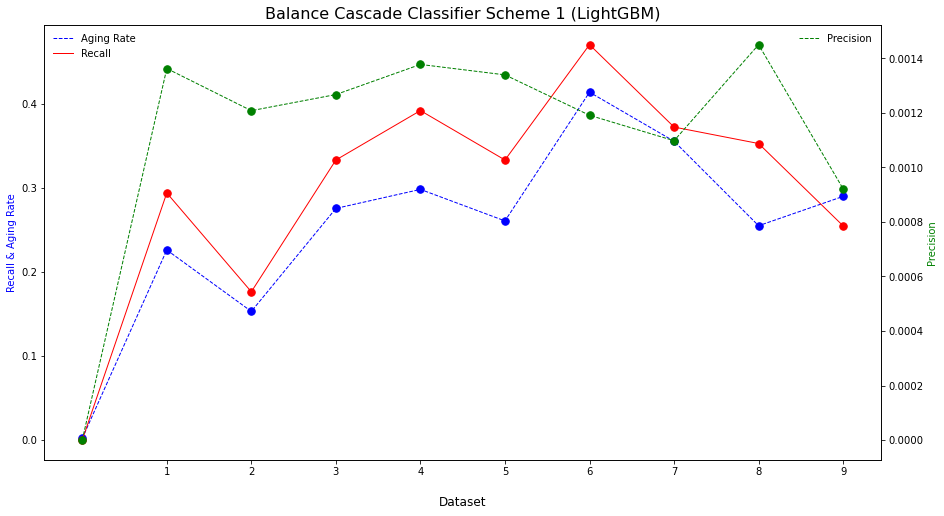

In [49]:
table_setC = runall_cascade(run_train, run_test, base_paramC, num_iter = 5)
line_chart(table_setC, title = 'Balance Cascade Classifier Scheme 1 (LightGBM)')

#### scheme 2

In [37]:
BC = BalanceCascade(base_clf = 'LightGBM', num_iter = 10, over_method = 'ADASYN', over_num = 10)
clf_cascade, clf_threshold = BC.training(run_train['set4'], best_paramC['set4'])
result = BC.testing(run_test, clf_cascade, clf_threshold)
cf_matrix(result, run_train_y['set4'])

Size before Oversampling: 15756
Size after Oversampling: 30323
Stop oversampling !
[LightGBM] [Warning] Unknown parameter: num_iter
[LightGBM] [Warning] Unknown parameter: over_num
[LightGBM] [Warning] Unknown parameter: over_method
Size before Oversampling: 14289
Size after Oversampling: 19787
[LightGBM] [Warning] Unknown parameter: num_iter
[LightGBM] [Warning] Unknown parameter: over_num
[LightGBM] [Warning] Unknown parameter: over_method
Size before Oversampling: 12964
Size after Oversampling: 18432
[LightGBM] [Warning] Unknown parameter: num_iter
[LightGBM] [Warning] Unknown parameter: over_num
[LightGBM] [Warning] Unknown parameter: over_method
Size before Oversampling: 11767
Size after Oversampling: 17279
[LightGBM] [Warning] Unknown parameter: num_iter
[LightGBM] [Warning] Unknown parameter: over_num
[LightGBM] [Warning] Unknown parameter: over_method
Size before Oversampling: 10686
Size after Oversampling: 16184
[LightGBM] [Warning] Unknown parameter: num_iter
[LightGBM] [Warn

,Balance Ratio,Train_OK,Train_NG,TP,FP,FN,TN,Precision,Recall,Aging Rate,Efficiency,Score
0,25.0,15150.0,606.0,38.0,32366.0,13.0,16232.0,0.001173,0.745098,0.666077,1.118636,0.559399



 Dataset 0:
Size before Oversampling: 157148
Size after Oversampling: 164379
Size before Oversampling: 49514
Size after Oversampling: 50701
Size before Oversampling: 15743
Size after Oversampling: 16930
Size before Oversampling: 5148
Size after Oversampling: 6331
Size before Oversampling: 1823
Size after Oversampling: 3006
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.004193303048366873

 Dataset 1:
Size before Oversampling: 15340
Size after Oversampling: 29540
Stop oversampling !
Size before Oversampling: 10453
Size after Oversampling: 12808
Size before Oversampling: 7185
Size after Oversampling: 9607
Size before Oversampling: 5000
Size after Oversampling: 7334
Size before Oversampling: 3539
Size after Oversampling: 5855
Precision: 0.001390894987428449 
Recall: 0.5098039215686274 
Aging Rate: 0.3842422249172645

 Dataset 2:
Size before Oversampling: 23556
Size after Oversampling: 45343
Stop oversampling !
Size before Oversampling: 16052
Size after Oversampling: 19721
Size before Oversam

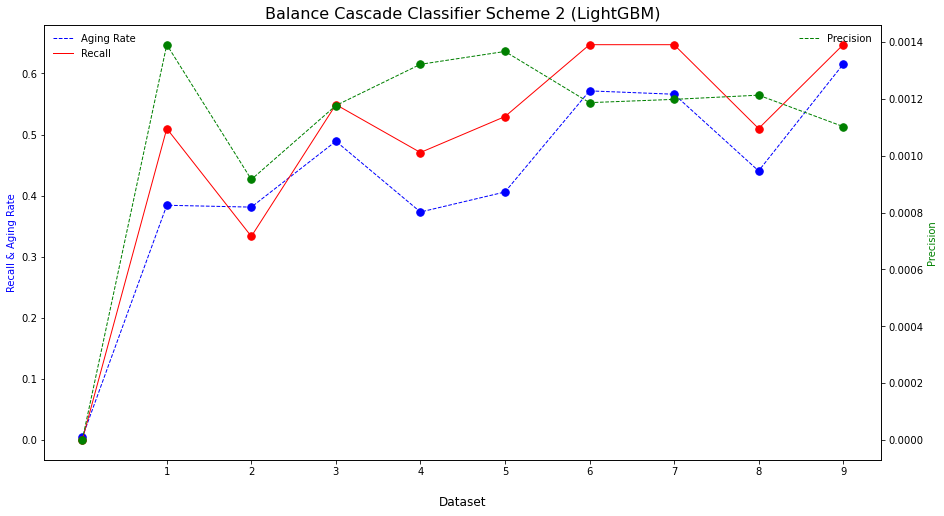

In [47]:
table_setC = runall_cascade(run_train, run_test, base_config = base_paramC, meta_config = meta_paramC)
line_chart(table_setC, title = 'Balance Cascade Classifier Scheme 2 (LightGBM)')

### export

In [10]:
table_setC

,Balance Ratio,Train_OK,Train_NG,TP,FP,FN,TN,Precision,Recall,Aging Rate,Efficiency,Score
dataset 0,515.934211,156844.0,304.0,0.0,0.0,51.0,48598.0,0.000000,0.000000,0.000000,0.000000,NaN
dataset 1,25.000000,38550.0,1542.0,1.0,623.0,50.0,47975.0,0.001603,0.019608,0.012827,1.528689,0.018190
dataset 2,25.000000,44550.0,1782.0,3.0,3496.0,48.0,45102.0,0.000857,0.058824,0.071923,0.817864,0.000000
dataset 3,25.000000,45475.0,1819.0,0.0,1576.0,51.0,47022.0,0.000000,0.000000,0.032395,0.000000,0.000000
dataset 4,25.000000,37950.0,1518.0,0.0,1184.0,51.0,47414.0,0.000000,0.000000,0.024338,0.000000,0.000000
dataset 5,25.049440,38000.0,1517.0,0.0,0.0,51.0,48598.0,0.000000,0.000000,0.000000,0.000000,NaN
dataset 6,16.142736,38000.0,2354.0,0.0,0.0,51.0,48598.0,0.000000,0.000000,0.000000,0.000000,NaN
dataset 7,20.982882,38000.0,1811.0,3.0,3018.0,48.0,45580.0,0.000993,0.058824,0.062098,0.947271,0.000000
dataset 8,25.000000,38000.0,1520.0,0.0,1026.0,51.0,47572.0,0.000000,0.000000,0.021090,0.000000,0.000000
dataset 9,25.000000,7600.0,304.0,8.0,6055.0,43.0,42543.0,0.001319,0.156863,0.124627,1.258653,0.127807


In [48]:
savedate = '20220222'
TPE_multi = False

table_setC['sampler'] = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
table_setC['model'] = 'BalanceCascade_br25_over2_iter5_over5_scheme2'
with pd.ExcelWriter(f'{savedate}_Classifier.xlsx', mode = 'a') as writer:
    table_setC.to_excel(writer, sheet_name = 'Cascade_scheme2_over2_iter5_over5')

C:\Users\user\anaconda3\envs\aging\lib\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


In [50]:
savedate = '20220222'
TPE_multi = False

table_setC['sampler'] = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
table_setC['model'] = 'BalanceCascade_br25_over2_iter5_scheme1'
with pd.ExcelWriter(f'{savedate}_Classifier.xlsx', mode = 'a') as writer:
    table_setC.to_excel(writer, sheet_name = 'Cascade_scheme1_over2_iter5')

C:\Users\user\anaconda3\envs\aging\lib\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")
